# Libraries 

In [1]:
import pandas as pd
import numpy as np
from Content_Object import *
from LFUCache import *
from LRUCache import *
from OPT import *
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_rows', None)

# Functions

In [153]:
def readData(path):
    print("Reading data from"+path)
    df=pd.read_csv(path)
    print(df.shape)
    display(df.head())
    return df

def colmnDiff(dfOld, dfNew):
    print("Old Feature:")
    oldClmns= list(dfOld.columns)
    print(oldClmns)
    print("New Feature:")
    diffClms= list(set(dfNew.columns).difference(set(dfOld.columns)))
    print(diffClms)
    return diffClms

def getUnique(df):
    Cols= df.columns
    print("Unique values for columns")
    for col in Cols:
        n= df[col].nunique()
        print(col, n)
        Uni= pd.unique(df[col])
        if n > 15:
            print(Uni[:5], "...", Uni[-5:])
        else:
            print(Uni)
    
def plotAll(df, col2="response_status"):
    print("How is everything related to hit\miss")
    for col in df.columns:
        df.groupby([col, col2]).size().unstack().nlargest(25,'tcp_hit').plot(kind='bar', stacked=True)
        plt.show()
            
def get_HR(df, algo="response"):
    OHR= df[df[algo+"_status"]=="tcp_hit"].shape[0]/df.shape[0] *100
    BHR= df[df[algo+"_status"]=="tcp_hit"]["byte_sent"].sum()/df["byte_sent"].sum() *100
    print(algo+" OHR: ",OHR," BHR: ",BHR, "#requests", df.shape[0])
    
def encodeCol(df, col):
    dfnew=df
    dfnew[col] = df[col].astype('category').cat.codes
    return dfnew

def sortTime(dfpass):
    df=dfpass.copy()
    df['time_received'] = pd.to_datetime(df['time_received'])
    df = df.sort_values('time_received')
    df = df.reset_index(drop=True)
    return df

def getIntialCache(df, object_id_set):
    print("#requests:", df.shape[0])
    df1 = df.drop_duplicates(subset=object_id_set)
    df_hit = df1[df1.response_status == 'tcp_hit']
    df_hit = df_hit.reset_index(drop=True)
    df_hit['object_id'] = df_hit.index
    df_initial = df_hit[['object_id'] + object_id_set]
    print("#cached requests",df_initial.shape[0])
    return df_initial

def filterHost(df, host):
    dfNew=df[df['host_id'] == host]
    dfNew = dfNew.reset_index(drop=True)
    return dfNew

def addObjectId(dfpass, df_initial, object_id_set):
    df=dfpass.copy()
    content = Content_Object(df_initial, object_id_set)
    object_id = [None] * df.shape[0]
    df_object_id= df.loc[:,object_id_set]

    for index in range(df.shape[0]):
        object_id[index]= int(content.getid(tuple(df_object_id.loc[index,:].values)))
        if index%100000==0:
            print(index)
    df.loc[:,"object_id"]= object_id
    print("#/% of distinct objects:", max(object_id), max(object_id)/df.shape[0]*100)
    return df

def perpareForAlgo(df):
    df_algo= df[['object_id','byte_sent']]
    df_algo['time']= df_algo.index
    df_algo1= df_algo[['time', 'object_id', 'byte_sent']]
    display(df_algo1.head())
    return df_algo1

def getHitRatesAlgo(item):
    N= np.sum(item["segment_object_req"])
    OHR= (N- np.sum(item["segment_object_miss"])) / N *100
    N= np.sum(item["segment_byte_req"])
    BHR= (N- np.sum(item["segment_byte_miss"])) / N *100
    return OHR, BHR

def pltDict(D, name):
    figure(figsize=(6,3))
    br= plt.bar(range(len(D)), [round(num, 2) for num in list(D.values())] , align='center')
    plt.xticks(range(len(D)), list(D.keys()), rotation='vertical')
    plt.ylim([min(D.values())-2, max(D.values())+10])
    plt.title(name)
    plt.bar_label(br)
    plt.show()

def pltTraffic(dfpass):
    df=dfpass.copy()
    print("Time Range:", min(df['time_received']), max(df['time_received']), "#requests:", df.shape[0])
    df= sortTime(df)
    ax = df.groupby(['time_received', 'host_id']).size().unstack().plot(figsize=(14,4))
    ax.set_ylabel("#requests/s")
    
def pltnunique(dfpass):
    df=dfpass.copy()
    df.nunique().sort_values(ascending=False).plot(kind='bar', figsize=(14,4), logy=True, rot=45)
    plt.ylabel("#distinct")
    plt.show()

def getMaxUnique(df, col1, col2):
    print(str(col1), "has max:", max(df.groupby(col1)[col2].nunique()), str(col2))

def deleteZeroByte(dfpass):  
    df=dfpass.copy()
    before=df.shape[0]
    df['byte_sent']= df['byte_sent'].astype(int)
    df=df[df['byte_sent'] != 0]
    print("#rows deleted:", before- df.shape[0])
    return df

def getNumUnique(df, cols):
    n=df.groupby(cols).size().shape[0]
    print(df.shape[0], n, (1-n/df.shape[0])*100)

# Exploratory Data Analysis

## Read data

In [3]:
dfOld=readData('../../Data/cdndataset_full.csv')
dfLive=readData('../../Data/Live_DSLab01.csv')
dfVoD=readData('../../Data/VoD_DSLab01.csv')

Reading data from../../Data/cdndataset_full.csv
(5261829, 15)


Unnamed: 0        time_received     byte_sent  host_id  time_to_serve  \
0           2  2021-10-13 06:59:46  25276.555556        1       0.154427   
1           3  2021-10-13 06:59:46  25276.555556        1       0.250970   
2           4  2021-10-13 06:59:46  15945.666667        1       0.000662   
3           5  2021-10-13 06:59:46    531.158730        1       0.000200   
4           7  2021-10-13 06:59:46    535.095238        1       0.000204   

  response_status  content_type request_method  user_id  session_id  \
0         tcp_hit             2       HTTP/1.1      0.0         2.0   
1        tcp_miss             2       HTTP/1.1      NaN         3.0   
2         tcp_hit             2       HTTP/1.1      1.0         4.0   
3         tcp_hit             2       HTTP/1.1      1.0         4.0   
4         tcp_hit             2       HTTP/1.1      2.0         6.0   

   live_tv_id  vod_id  vod_encoding  user_ip  request_header  
0         0.0     NaN           NaN      1.0             1.0  
1         0.0     NaN           NaN      1.0             1.0  
2         1.0     NaN           NaN      1.0             2.0  
3         1.0     NaN           NaN      1.0             2.0  
4         2.0     NaN           NaN      1.0             1.0

Reading data from../../Data/Live_DSLab01.csv
(2161721, 22)


device_type  live_tv_id  request_url request_method  \
0          0.0         NaN       112784       HTTP/1.1   
1          0.0         NaN       112784       HTTP/1.1   
2          0.0         NaN      1068243       HTTP/1.1   
3          0.0         NaN      6182324       HTTP/1.1   
4         11.0         NaN     55175944       HTTP/1.1   

               time_received  user_loc     byte_sent  vod_encoding  \
0  2021-11-14 13:09:01+00:00         0    236.619048           NaN   
1  2021-11-14 01:29:08+00:00         0    236.619048           NaN   
2  2021-11-14 01:29:08+00:00         0     28.031746           NaN   
3  2021-11-14 00:09:02+00:00         0   1542.523810           NaN   
4  2021-11-14 00:11:32+00:00         1  26949.650794           NaN   

   time_to_serve              content_type   maxage  session_id  \
0       0.043994      application/dash+xml      2.0       92486   
1       0.042179      application/dash+xml      2.0      947730   
2       0.043618  application/octet-stream      4.0      947730   
3       0.008703                 video/mp4  21600.0       67509   
4       0.109556                video/MP2T  21600.0      532399   

                  cachecontrol method response_status  user_id  host_id  \
0      Cache-Control:max-age=2    GET        tcp_miss      NaN        2   
1      Cache-Control:max-age=2    GET        tcp_miss      NaN        2   
2      Cache-Control:max-age=4    GET        tcp_miss      NaN        2   
3  Cache-Control:max-age=21600    GET        tcp_miss      NaN        2   
4  Cache-Control:max-age=21600    GET        tcp_miss      NaN        2   

   vod_id  devicebrand  statuscode  user_agent  request_header  
0     NaN          NaN         200         3.0            49.0  
1     NaN          NaN         200         3.0            49.0  
2     NaN          NaN         200         3.0            49.0  
3     NaN          NaN         200         3.0            49.0  
4     NaN          1.0         200         6.0             NaN

Reading data from../../Data/VoD_DSLab01.csv
(1577063, 22)


device_type  live_tv_id  request_url request_method  \
0          0.0         NaN     73218596       HTTP/1.1   
1          0.0         NaN     74962598       HTTP/1.1   
2          0.0         NaN     74687485       HTTP/1.1   
3          0.0         NaN     73908576       HTTP/1.1   
4          0.0         NaN     74687475       HTTP/1.1   

               time_received  user_loc     byte_sent  vod_encoding  \
0  2021-11-14 06:00:14+00:00         0   1542.095238          10.0   
1  2021-11-14 06:19:57+00:00      1816  70985.984127        1659.0   
2  2021-11-14 06:21:14+00:00       944  65501.857143        2673.0   
3  2021-11-14 06:21:18+00:00         0  73345.412698        2580.0   
4  2021-11-14 06:22:01+00:00       944   1579.349206        2673.0   

   time_to_serve content_type      maxage  session_id  \
0       0.000274   video/mpeg  31536000.0      958280   
1       0.430289    video/mp4  31536000.0      958702   
2       2.474124    video/mp4  31536000.0      958674   
3       0.380959    video/mp4  31536000.0      958739   
4       0.000244   video/mpeg  31536000.0      958670   

                     cachecontrol method response_status  user_id  host_id  \
0  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
1  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
2  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
3  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
4  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   

   vod_id  devicebrand  statuscode  user_agent  request_header  
0  2751.0          NaN         206        12.0             NaN  
1  3031.0          NaN         206        12.0             NaN  
2  2978.0          NaN         206        12.0             NaN  
3  2868.0          NaN         206        12.0             NaN  
4  2978.0          NaN         206        12.0             NaN

In [4]:
dfLive= dfLive.fillna("-1")
dfVoD= dfVoD.fillna("-1")
dfOld= dfOld.fillna("-1")

## Check provided features

In [6]:
diffClms= colmnDiff(dfOld, dfLive)

Old Feature:
['Unnamed: 0', 'time_received', 'byte_sent', 'host_id', 'time_to_serve', 'response_status', 'content_type', 'request_method', 'user_id', 'session_id', 'live_tv_id', 'vod_id', 'vod_encoding', 'user_ip', 'request_header']
New Feature:
['device_type', 'user_agent', 'request_url', 'devicebrand', 'method', 'statuscode', 'maxage', 'user_loc', 'cachecontrol']


## Traffic Analysis

Time Range: 2021-10-13 06:59:45 2021-10-13 10:14:48 #requests: 5261829
Time Range: 2021-11-13 06:59:04+00:00 2021-11-16 00:00:00+00:00 #requests: 2161721
Time Range: 2021-11-13 06:59:04+00:00 2021-11-16 00:00:00+00:00 #requests: 1577063


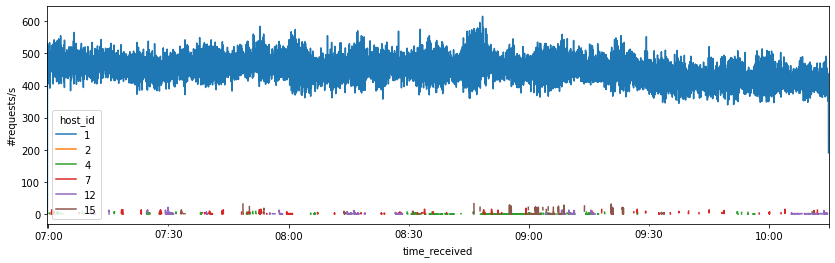

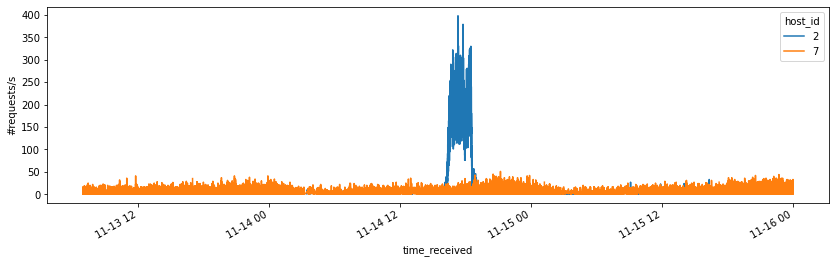

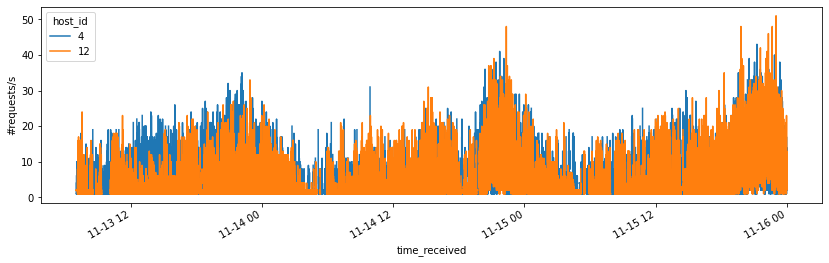

In [6]:
pltTraffic(dfOld)
pltTraffic(dfLive)
pltTraffic(dfVoD)

## dfs per host

In [168]:
dfDict= {}
dfDict['1']=filterHost(dfOld, 1)
dfDict['7']=filterHost(dfLive, 7)
dfDict['2']=filterHost(dfLive, 2)
dfDict['4']=filterHost(dfVoD, 4)
dfDict['12']=filterHost(dfVoD, 12)

## sorting by time

In [169]:
for key in dfDict:
    dfDict[key]= sortTime(dfDict[key])

## unique values

In [24]:
for key in dfDict:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    getUnique(dfDict[key])

1 ----- 5253386 ---------------------------------------------------------------------------------
Unique values for columns
Unnamed: 0 5253386
[2 3 4 5 7] ... [9999994 9999995 9999996 9999997 9999998]
time_received 11704
['2021-10-13 06:59:46' '2021-10-13 06:59:45' '2021-10-13 06:59:47'
 '2021-10-13 06:59:48' '2021-10-13 06:59:49'] ... ['2021-10-13 10:14:44' '2021-10-13 10:14:45' '2021-10-13 10:14:46'
 '2021-10-13 10:14:47' '2021-10-13 10:14:48']
byte_sent 331995
[25276.55555556 15945.66666667   531.15873016   535.0952381
 14793.65079365] ... [28654.65079365 15938.15873016  8614.53968254 15589.53968254
 24168.31746032]
host_id 1
[1]
time_to_serve 441300
[1.54427e-01 2.50970e-01 6.62000e-04 2.00000e-04 2.04000e-04] ... [0.20358  0.395176 0.616494 0.769533 0.756069]
response_status 2
['tcp_hit' 'tcp_miss']
content_type 4
[2 1 3 0]
request_method 1
['HTTP/1.1']
user_id 1039
[0.0 '-1' 1.0 2.0 3.0] ... [1064.0 1065.0 1067.0 1068.0 1069.0]
session_id 2884
[2. 3. 4. 6. 7.] ... [4976. 4980. 49

['GET']
response_status 2
['tcp_miss' 'tcp_hit']
user_id 842
['-1' 14562.0 24687.0 8294.0 14447.0] ... [25368.0 16835.0 27742.0 17953.0 17987.0]
host_id 1
[12]
vod_id 864
[551.0 2742.0 552.0 199.0 180.0] ... [2189.0 2196.0 2188.0 2193.0 728.0]
devicebrand 4
['-1' 4.0 0.0 6.0]
statuscode 3
[200 403 503]
user_agent 6
['-1' 12.0 1.0 8.0 2.0 26.0]
request_header 6
['-1' 0.0 19.0 8.0 1.0 33.0]


### Based on the unique values, we are curious about the following:
- we will delete not useful colmns- ex: with only one value
- byte_sent is low and double value
- statuscode records for 40*, 50*
- maxage vs cachecontrol, and study no cache
- relations between features

## clear

In [39]:
dfDict['1'].drop(['host_id','request_method','Unnamed: 0'], axis=1, inplace=True)
for key in dfDict:
    if key == '1':
        continue
    dfDict[key].drop(['host_id','request_method','method'], axis=1, inplace=True)

## byte_sent

In [43]:
# unique values of fractional part
for key in dfDict:
    print(key, "--------------------------------------------------------------------------------------")
    print(np.unique(np.modf(dfDict[key]['byte_sent'])[0]))

1 --------------------------------------------------------------------------------------
[0.         0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.03174603 0.03174603 0.03174603 0.03174603 0.03174603 0.03174603
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.06349206 0.06349206 0.06349206 0.06349206 0.07936508 0.07936508
 0.07936508 0.07936508 0.07936508 0.07936508 0.07936508 0.07936508
 0.07936508 0.07936508 0.0952381  0.0952381  0.0952381  0.0952381
 0.0952381  0.0952381  0.0952381  0.0952381  0.0952381  0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.12698413 0.12698413 0.12698413 0.12698413 0.12698413
 0.12698413 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714 0.14285714 0.15873016 0.15873016 0.15873016
 0.15873016 0.15873016 0.15873016 0.15873016 0.15873016 0.15873016
 0.15873016 0.15873016 0.17460317 0.17460317 0.17460317 0.17460317
 0.17460317 0.17460317 0.17460317 0.17460

In [44]:
1/0.01587302

62.99998362000425

In [10]:
np.unique(np.modf(dfLive['byte_sent']*63)[0])

array([0.00000000e+00, 5.68434189e-14, 1.13686838e-13, 2.27373675e-13,
       4.54747351e-13, 9.09494702e-13, 1.81898940e-12, 3.63797881e-12,
       7.27595761e-12, 1.45519152e-11, 2.91038305e-11, 4.36557457e-11,
       5.82076609e-11, 7.27595761e-11, 8.73114914e-11, 1.16415322e-10,
       2.32830644e-10, 4.65661287e-10, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00])

In [170]:
# multiply by 63 and make int and remove zero size
for key in dfDict:
    print(key, "--------------------------------------------------------------------------------------")
    dfDict[key]['byte_sent']= dfDict[key]['byte_sent'] *63
    dfDict[key]= deleteZeroByte(dfDict[key])

1 --------------------------------------------------------------------------------------
#rows deleted: 7
7 --------------------------------------------------------------------------------------
#rows deleted: 595
2 --------------------------------------------------------------------------------------
#rows deleted: 0
4 --------------------------------------------------------------------------------------
#rows deleted: 0
12 --------------------------------------------------------------------------------------
#rows deleted: 0


## statuscode

In [14]:
# unique values
for key in dfDict:
    if key == '1':
        continue
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['statuscode'].value_counts())

7 --------------------------------------------------------------------------------------
206    520381
200     50475
400     12825
412      5232
503       170
Name: statuscode, dtype: int64
2 --------------------------------------------------------------------------------------
200    1567950
404       4087
403          6
Name: statuscode, dtype: int64
4 --------------------------------------------------------------------------------------
206    714997
200       850
403         9
503         2
Name: statuscode, dtype: int64
12 --------------------------------------------------------------------------------------
200    861196
403         8
503         1
Name: statuscode, dtype: int64


In [40]:
# filter and get some values
error_codes= [400,412,404,503,403]
# unique values
for key in dfDict:
    df=dfDict[key]
    if key == '1':
        continue
    print(key, "--------------------------------------------------------------------------------------")
    display(df[df['statuscode'].isin(error_codes)].head())

7 --------------------------------------------------------------------------------------


device_type live_tv_id  request_url              time_received  user_loc  \
9           0.0       60.0     60595704  2021-11-15 15:22:35+00:00       808   
42           -1       60.0     19900871  2021-11-15 15:35:01+00:00       206   
91          0.0         -1         2457  2021-11-15 15:51:55+00:00        23   
106         0.0         -1         2457  2021-11-15 03:10:35+00:00        31   
160         0.0       60.0     19953647  2021-11-15 15:42:54+00:00        40   

     byte_sent vod_encoding  time_to_serve              content_type maxage  \
9    23.888889           -1       0.007328                 text/html     -1   
42   23.888889           -1       0.014416                 text/html     -1   
91    2.714286           -1       0.015496  text/html; charset=utf-8     -1   
106   2.714286           -1       0.016003  text/html; charset=utf-8     -1   
160  23.888889           -1       0.013508                 text/html     -1   

     session_id    cachecontrol response_status user_id vod_id devicebrand  \
9        628768  Cache-Control:        tcp_miss      -1     -1          -1   
42       183443  Cache-Control:        tcp_miss      -1     -1          -1   
91       629666  Cache-Control:        tcp_miss      -1     -1          -1   
106      612431  Cache-Control:        tcp_miss      -1     -1          -1   
160      183758  Cache-Control:        tcp_miss      -1     -1          -1   

     statuscode user_agent request_header  
9           412       12.0             -1  
42          412         -1             -1  
91          400       12.0             -1  
106         400       12.0             -1  
160         412       12.0             -1

2 --------------------------------------------------------------------------------------


device_type live_tv_id  request_url              time_received  user_loc  \
1429         0.0         -1          935  2021-11-13 22:13:12+00:00     10508   
2749       267.0         -1      9101579  2021-11-13 11:23:48+00:00         0   
3433         9.0         -1     74677376  2021-11-13 21:33:12+00:00         1   
3616         1.0         -1          307  2021-11-13 20:10:28+00:00         1   
3621         1.0         -1          307  2021-11-13 20:13:09+00:00         1   

      byte_sent vod_encoding  time_to_serve                   content_type  \
1429   2.317460           -1       0.034321                      text/html   
2749   0.285714           -1       0.028095  text/html; charset=iso-8859-1   
3433   0.285714           -1       0.027101  text/html; charset=iso-8859-1   
3616   0.285714           -1       0.037054  text/html; charset=iso-8859-1   
3621   0.285714           -1       0.037874  text/html; charset=iso-8859-1   

     maxage  session_id    cachecontrol response_status user_id vod_id  \
1429     -1      522491  Cache-Control:        tcp_miss      -1     -1   
2749     -1      478793  Cache-Control:        tcp_miss      -1     -1   
3433     -1      931767  Cache-Control:        tcp_miss      -1     -1   
3616     -1       40745  Cache-Control:        tcp_miss      -1     -1   
3621     -1       39851  Cache-Control:        tcp_miss      -1     -1   

     devicebrand  statuscode user_agent request_header  
1429          -1         403        1.0             -1  
2749         8.0         404        2.0           19.0  
3433         1.0         404        1.0             -1  
3616         0.0         404        1.0             -1  
3621         0.0         404        1.0             -1

4 --------------------------------------------------------------------------------------


device_type live_tv_id  request_url              time_received  \
2007           0.0         -1          935  2021-11-14 06:53:32+00:00   
6834           0.0         -1          935  2021-11-14 19:32:10+00:00   
58630          0.0         -1          935  2021-11-13 23:37:59+00:00   
99653          0.0         -1          935  2021-11-13 20:18:39+00:00   
122653         0.0         -1          935  2021-11-15 17:02:05+00:00   

        user_loc  byte_sent vod_encoding  time_to_serve content_type  maxage  \
2007       10508  19.571429           -1       0.014980    text/html  7200.0   
6834       10508  19.571429           -1       0.015373    text/html  7200.0   
58630        238  19.571429           -1       0.015377    text/html  7200.0   
99653        238  19.571429           -1       0.014446    text/html  7200.0   
122653     10508  19.571429           -1       0.027107    text/html  7200.0   

        session_id                cachecontrol response_status user_id vod_id  \
2007        546914  Cache-Control:max-age=7200        tcp_miss      -1     -1   
6834        130570  Cache-Control:max-age=7200        tcp_miss      -1     -1   
58630       942679  Cache-Control:max-age=7200        tcp_miss      -1     -1   
99653       511671  Cache-Control:max-age=7200        tcp_miss      -1     -1   
122653     1038328  Cache-Control:max-age=7200        tcp_miss      -1     -1   

       devicebrand  statuscode user_agent request_header  
2007            -1         403        1.0             -1  
6834            -1         403        1.0             -1  
58630           -1         403        1.0             -1  
99653           -1         403        1.0             -1  
122653          -1         403        1.0             -1

12 --------------------------------------------------------------------------------------


device_type live_tv_id  request_url              time_received  \
542            0.0         -1          935  2021-11-14 18:35:15+00:00   
75052          0.0         -1          935  2021-11-13 08:46:49+00:00   
98606          0.0         -1          935  2021-11-13 10:36:37+00:00   
150387         0.0         -1          935  2021-11-13 23:22:38+00:00   
232597         0.0         -1          935  2021-11-14 11:55:30+00:00   

        user_loc  byte_sent vod_encoding  time_to_serve content_type  maxage  \
542        10508  19.571429           -1       0.021934    text/html  7200.0   
75052        238  19.571429           -1       0.020189    text/html  7200.0   
98606        238  19.571429           -1       0.021090    text/html  7200.0   
150387     10508  19.571429           -1       0.021120    text/html  7200.0   
232597     10508  19.571429           -1       0.019397    text/html  7200.0   

        session_id                cachecontrol response_status user_id vod_id  \
542         573029  Cache-Control:max-age=7200        tcp_miss      -1     -1   
75052       475309  Cache-Control:max-age=7200        tcp_miss      -1     -1   
98606       892473  Cache-Control:max-age=7200        tcp_miss      -1     -1   
150387      941627  Cache-Control:max-age=7200        tcp_miss      -1     -1   
232597       90533  Cache-Control:max-age=7200        tcp_miss      -1     -1   

       devicebrand  statuscode user_agent request_header  
542             -1         403        1.0             -1  
75052           -1         403        1.0             -1  
98606           -1         403        1.0             -1  
150387          -1         403        1.0             -1  
232597          -1         403        1.0             -1

Questions:
- do error requests get cached? let's see hit miss
https://support.huaweicloud.com/intl/en-us/cdn_faq/cdn_faq_0136.html

In [16]:
for key in dfDict:
    df=dfDict[key]
    if key == '1':
        continue
    print(key, "--------------------------------------------------------------------------------------")
    display(df[df['statuscode'].isin(error_codes)]['response_status'].value_counts())

7 --------------------------------------------------------------------------------------


tcp_miss    18227
Name: response_status, dtype: int64

2 --------------------------------------------------------------------------------------


tcp_miss    4093
Name: response_status, dtype: int64

4 --------------------------------------------------------------------------------------


tcp_miss    11
Name: response_status, dtype: int64

12 --------------------------------------------------------------------------------------


tcp_miss    9
Name: response_status, dtype: int64

In [171]:
# as they all miss, let's delete these rows
for key in dfDict:
    df=dfDict[key]
    if key == '1':
        continue
    dfDict[key]=df[~df['statuscode'].isin(error_codes)]

In [172]:
# check non left
for key in dfDict:
    if key == '1':
        continue
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['statuscode'].value_counts())

7 --------------------------------------------------------------------------------------
206    520381
200     50475
Name: statuscode, dtype: int64
2 --------------------------------------------------------------------------------------
200    1567950
Name: statuscode, dtype: int64
4 --------------------------------------------------------------------------------------
206    714997
200       850
Name: statuscode, dtype: int64
12 --------------------------------------------------------------------------------------
200    861196
Name: statuscode, dtype: int64


## maxage vs cachecontrol, and study no cache

In [22]:
for key in dfDict:
    if key == '1':
        continue
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['cachecontrol'].value_counts())
    print(dfDict[key]['maxage'].value_counts())

7 --------------------------------------------------------------------------------------
Cache-Control:Cache-Control: max-age=60    306372
Cache-Control:max-age=120                   99500
Cache-Control:max-age=3600                  98982
Cache-Control:max-age=60                    51143
Cache-Control:no-cache                       9150
Cache-Control:max-age=1                      3756
Cache-Control:max-age=2                      1953
Name: cachecontrol, dtype: int64
60.0      357515
120.0      99500
3600.0     98982
-1          9150
1.0         3756
2.0         1953
Name: maxage, dtype: int64
2 --------------------------------------------------------------------------------------
Cache-Control:max-age=21600    996238
Cache-Control:max-age=2        566041
Cache-Control:max-age=4          5671
Name: cachecontrol, dtype: int64
21600.0    996238
2.0        566041
4.0          5671
Name: maxage, dtype: int64
4 --------------------------------------------------------------------------------

#### They seems exactly the same with -1 means no cache, so we will remove Cache-Control, and work with max-age 

In [173]:
# drop cachecontrol
for key in dfDict:
    if key == '1':
        continue
    dfDict[key].drop(['cachecontrol'], inplace=True, axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [174]:
# check if no cache is considered -> miss
for key in dfDict:
    df=dfDict[key]
    if key == '1':
        continue
    print(key, "--------------------------------------------------------------------------------------")
    display(df[df['maxage']=='-1']['response_status'].value_counts())

7 --------------------------------------------------------------------------------------


tcp_miss    9150
Name: response_status, dtype: int64

2 --------------------------------------------------------------------------------------


Series([], Name: response_status, dtype: int64)

4 --------------------------------------------------------------------------------------


tcp_miss    6884
Name: response_status, dtype: int64

12 --------------------------------------------------------------------------------------


tcp_miss    2496
Name: response_status, dtype: int64

In [175]:
# as they all miss, let's delete these rows
for key in dfDict:
    df=dfDict[key]
    if key == '1':
        continue
    dfDict[key]=df[df['maxage']!='-1']

In [176]:
# check non left
for key in dfDict:
    if key == '1':
        continue
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['maxage'].value_counts())

7 --------------------------------------------------------------------------------------
60.0      357515
120.0      99500
3600.0     98982
1.0         3756
2.0         1953
Name: maxage, dtype: int64
2 --------------------------------------------------------------------------------------
21600.0    996238
2.0        566041
4.0          5671
Name: maxage, dtype: int64
4 --------------------------------------------------------------------------------------
31536000.0    704541
7200.0          4422
Name: maxage, dtype: int64
12 --------------------------------------------------------------------------------------
31536000.0    857941
7200.0           759
Name: maxage, dtype: int64


## unique values

In [77]:
for key in dfDict:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    getUnique(dfDict[key])

1 ----- 5253379 ---------------------------------------------------------------------------------
Unique values for columns
time_received 11704
['2021-10-13 06:59:46' '2021-10-13 06:59:45' '2021-10-13 06:59:47'
 '2021-10-13 06:59:48' '2021-10-13 06:59:49'] ... ['2021-10-13 10:14:44' '2021-10-13 10:14:45' '2021-10-13 10:14:46'
 '2021-10-13 10:14:47' '2021-10-13 10:14:48']
byte_sent 318045
[1592423 1004577   33463   33711  931999] ... [1805243 1004104  542716  982141 1522604]
time_to_serve 441299
[1.54427e-01 2.50970e-01 6.62000e-04 2.00000e-04 2.04000e-04] ... [0.20358  0.395176 0.616494 0.769533 0.756069]
response_status 2
['tcp_hit' 'tcp_miss']
content_type 4
[2 1 3 0]
user_id 1037
[0.0 '-1' 1.0 2.0 3.0] ... [1064.0 1065.0 1067.0 1068.0 1069.0]
session_id 2882
[2. 3. 4. 6. 7.] ... [4976. 4980. 4981. 4982. 4984.]
live_tv_id 153
[0.0 1.0 2.0 3.0 4.0] ... [155.0 156.0 157.0 158.0 159.0]
vod_id 1
['-1']
vod_encoding 1
['-1']
user_ip 187
[ 1.  3.  8.  9. 10.] ... [ 486. 2336. 1067.  720.  

## Check number of distinct values for each feature

1


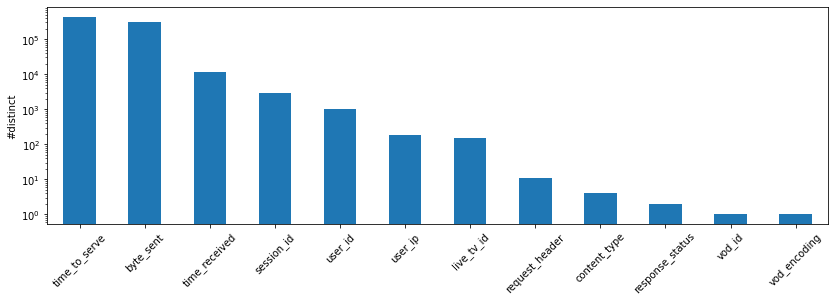

7


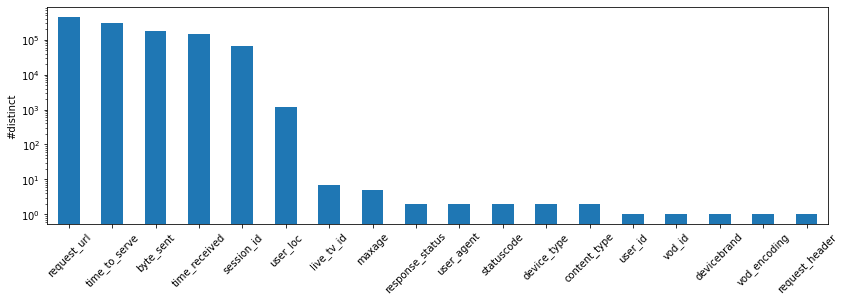

2


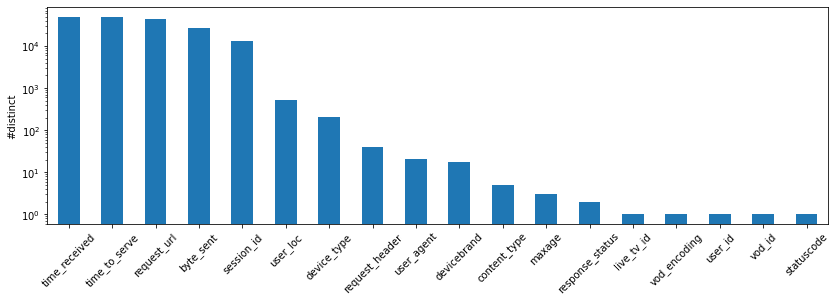

4


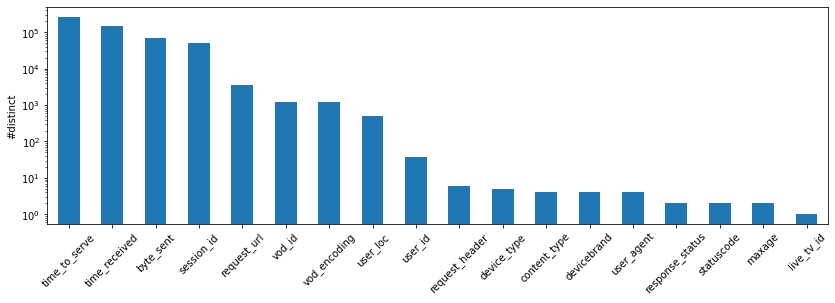

12


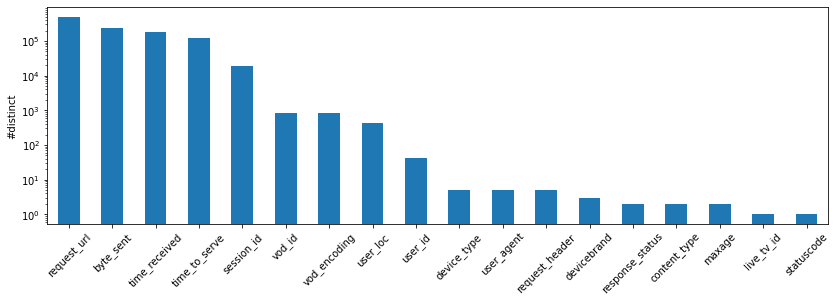

In [48]:
for key in dfDict:
    print(key)
    pltnunique(dfDict[key])

## Relation between features

### 'content_type', 'maxage' relation

7


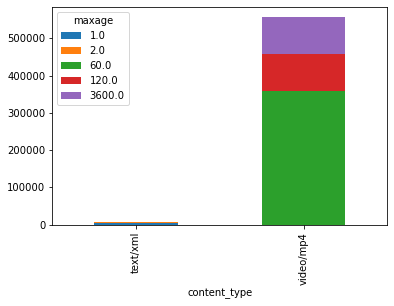

2


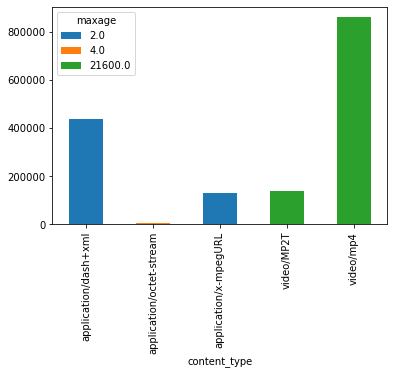

4


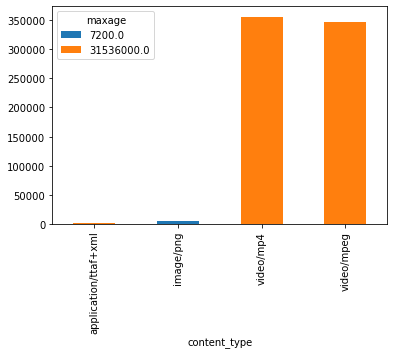

12


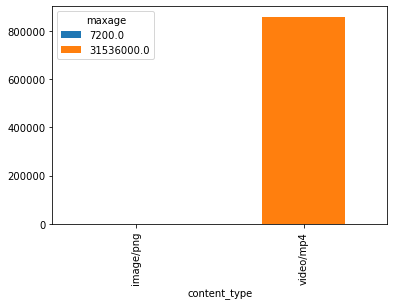

In [166]:
for key in dfDict:
    if key == '1':
        continue
    print(key)
    dfDict[key].groupby(['content_type', 'maxage']).size().unstack().plot(kind='bar', stacked=True)
    plt.show()

### 'content_type', 'statuscode' relation

7


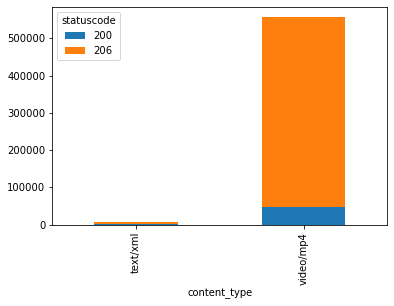

2


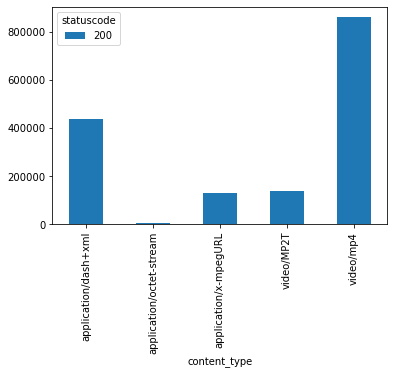

4


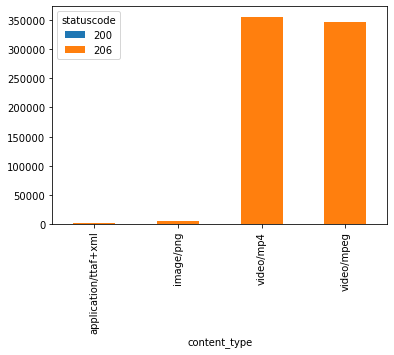

12


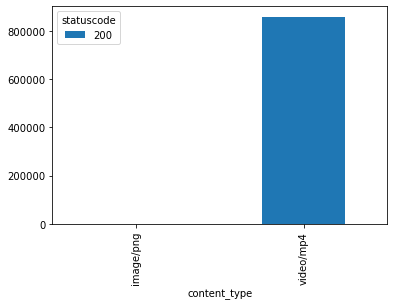

In [90]:
for key in dfDict:
    if key == '1':
        continue
    print(key)
    dfDict[key].groupby(['content_type', 'statuscode']).size().unstack().plot(kind='bar', stacked=True)
    plt.show()

### dfOld

In [92]:
print("-----", dfDict['1'].shape[0] ,"---------------------------------------------------------------------------------")
getMaxUnique(dfDict['1'], 'byte_sent', 'live_tv_id')
getMaxUnique(dfDict['1'], ['byte_sent', 'live_tv_id'], 'vod_id')
getMaxUnique(dfDict['1'], ['byte_sent', 'live_tv_id', 'vod_id'], 'content_type')

----- 5253379 ---------------------------------------------------------------------------------
byte_sent has max: 120 live_tv_id
['byte_sent', 'live_tv_id'] has max: 1 vod_id
['byte_sent', 'live_tv_id', 'vod_id'] has max: 2 content_type


### df new

In [138]:
for key in ['7','2','4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    getMaxUnique(dfDict[key], 'request_url', 'byte_sent')
    getMaxUnique(dfDict[key], 'request_url', 'live_tv_id')
    getMaxUnique(dfDict[key], 'request_url', 'vod_id')
    getMaxUnique(dfDict[key], 'request_url', 'content_type')

7 ----- 561706 ---------------------------------------------------------------------------------
request_url has max: 9 byte_sent
request_url has max: 1 live_tv_id
request_url has max: 1 vod_id
request_url has max: 1 content_type
2 ----- 1567950 ---------------------------------------------------------------------------------
request_url has max: 2279 byte_sent
request_url has max: 1 live_tv_id
request_url has max: 1 vod_id
request_url has max: 1 content_type
4 ----- 708963 ---------------------------------------------------------------------------------
request_url has max: 1199 byte_sent
request_url has max: 1 live_tv_id
request_url has max: 1 vod_id
request_url has max: 1 content_type
12 ----- 858700 ---------------------------------------------------------------------------------
request_url has max: 125 byte_sent
request_url has max: 1 live_tv_id
request_url has max: 1 vod_id
request_url has max: 1 content_type


### request_url , byte_sent

In [137]:
for key in ['7','2','4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    df=dfDict[key]
    display(np.unique(df.groupby('request_url')['byte_sent'].nunique(), return_counts=True))

7 ----- 561706 ---------------------------------------------------------------------------------


(array([1, 2, 3, 4, 5, 8, 9]),
 array([458971,   3186,    146,      6,      1,      1,      1]))

2 ----- 1567950 ---------------------------------------------------------------------------------


(array([   1,    2,    8,   17,   18,   27,   73,  229,  320, 1045, 1061,
        2178, 2276, 2279]),
 array([43638,    28,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1]))

4 ----- 708963 ---------------------------------------------------------------------------------


(array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
          34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
          45,   46,   47,   48,   49,   50,   51,   53,   54,   55,   56,
          57,   58,   59,   60,   61,   64,   67,   69,   74,   77,   82,
          83,   88,   89,   93,  100,  110,  112,  114,  118,  121,  122,
         125,  126,  129,  130,  131,  132,  133,  134,  135,  136,  137,
         138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
         149,  150,  153,  155,  156,  157,  162,  165,  166,  170,  171,
         172,  179,  180,  188,  200,  216,  220,  226,  233,  267,  271,
         287,  288,  351,  420,  428,  429,  430,  431,  432,  434,  436,
         437,  438,  440,  441,  442,  443,  446,  448,  449,  452,  453,
         454,  455,  456,  457,  458, 

12 ----- 858700 ---------------------------------------------------------------------------------


(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  17,  18,  19,  37, 125]),
 array([502742,   1376,     94,     33,     13,     11,      9,      3,
             2,      3,      1,      1,      2,      1,      1,      1,
             1,      2,      1,      1]))

### 'request_url', 'byte_sent' relation

In [115]:
def getN_connection(dfpass, col, MinOccur=-1):
    print(col)
    df=dfpass.copy()
    if MinOccur==-1:
        MinOccur= max(df.groupby('request_url')[col].nunique())
    dfgrp=pd.DataFrame({'count' :df.groupby(['request_url',col]).size()}).reset_index()
    dfgrp['Occur'] = dfgrp.groupby('request_url')[col].transform('size')
    dfmax= dfgrp[dfgrp['Occur']>=max(df.groupby('request_url')[col].nunique())]
    df2= dfgrp[dfgrp['Occur']>=MinOccur]
    display(dfmax.head(20))
    urlMax=dfmax['request_url'].unique()
    urls=df2['request_url'].unique()
    df[df['request_url']==urlMax[0]].hist("byte_sent", bins=50)
    plt.show()
    return df[df['request_url'].isin(urls)].sort_values('time_received')

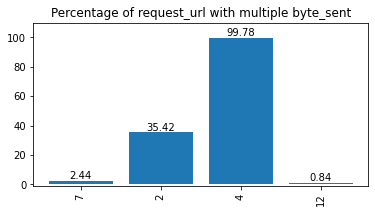

In [154]:
pltDict(dfPerc, "Percentage of request_url with multiple byte_sent")

7 ----- 561706 ---------------------------------------------------------------------------------
byte_sent


request_url  byte_sent  count  Occur
104        35546       1202      1      9
105        35546       1213      5      9
106        35546       1219      3      9
107        35546       1221      1      9
108        35546       1222      1      9
109        35546       1223     60      9
110        35546       1233    241      9
111        35546       1244    383      9
112        35546       1255   1043      9

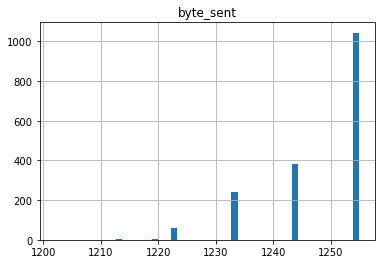

device_type live_tv_id  request_url request_method  \
561994          -1       58.0     23202617       HTTP/1.1   
562383          -1       58.0     23209082       HTTP/1.1   
562558          -1       58.0     23213893       HTTP/1.1   
562957          -1       82.0        83215       HTTP/1.1   
562998          -1       58.0     23223192       HTTP/1.1   
563017          -1       82.0        83215       HTTP/1.1   
563544          -1       58.0     23237813       HTTP/1.1   
563663          -1       58.0     23241755       HTTP/1.1   
563804          -1       58.0     23243780       HTTP/1.1   
563818          -1       58.0     23244600       HTTP/1.1   
564465          -1       58.0     23255638       HTTP/1.1   
565422          -1       60.0         6718       HTTP/1.1   
565864          -1       86.0     23280432       HTTP/1.1   
565904          -1       58.0     23280988       HTTP/1.1   
566406          -1       58.0     23292218       HTTP/1.1   
566680          -1       58.0     23296681       HTTP/1.1   
566693          -1       58.0     23297282       HTTP/1.1   
566712          -1       58.0     23297863       HTTP/1.1   
566923          -1       58.0     23301896       HTTP/1.1   
567132          -1       59.0     23305929       HTTP/1.1   
567133          -1       59.0     23305942       HTTP/1.1   
567167          -1       57.0     23306336       HTTP/1.1   
567191          -1       57.0     23306937       HTTP/1.1   
567353          -1       58.0     23310148       HTTP/1.1   
567348          -1       58.0     23310148       HTTP/1.1   
567411          -1       68.0        35546       HTTP/1.1   
568228          -1       82.0        83215       HTTP/1.1   
568749          -1       58.0     23339447       HTTP/1.1   
568746          -1       58.0     23339447       HTTP/1.1   
568874          -1       82.0        83215       HTTP/1.1   
568966          -1       82.0     79429704       HTTP/1.1   
568992          -1       82.0     61890713       HTTP/1.1   
568995          -1       82.0     61890714       HTTP/1.1   
569073          -1       82.0        83215       HTTP/1.1   
569090          -1       82.0     61890713       HTTP/1.1   
569343          -1       60.0         6718       HTTP/1.1   
569378          -1       60.0         6718       HTTP/1.1   
569523          -1       58.0     23350256       HTTP/1.1   
569520          -1       58.0     23350256       HTTP/1.1   
569810          -1       58.0     23354947       HTTP/1.1   
569811          -1       58.0     23354947       HTTP/1.1   
569812          -1       58.0     23354972       HTTP/1.1   
569817          -1       58.0     23354972       HTTP/1.1   
569818          -1       58.0     23354972       HTTP/1.1   
569822          -1       58.0     23354947       HTTP/1.1   
570130          -1       58.0     23361232       HTTP/1.1   
570137          -1       58.0     23361232       HTTP/1.1   
570379          -1       58.0     23365955       HTTP/1.1   
570382          -1       58.0     23365955       HTTP/1.1   
570387          -1       59.0     61898001       HTTP/1.1   
570422          -1       58.0     23367199       HTTP/1.1   
570428          -1       58.0     23367199       HTTP/1.1   
570767          -1       58.0     23372520       HTTP/1.1   
570772          -1       58.0     23372520       HTTP/1.1   
572404          -1       58.0     23400576       HTTP/1.1   
572438          -1       58.0     23401474       HTTP/1.1   
572881          -1       60.0         6718       HTTP/1.1   
573026          -1       59.0     61916116       HTTP/1.1   
573030          -1       59.0     61916118       HTTP/1.1   
573066          -1       59.0     61916118       HTTP/1.1   
573073          -1       59.0     61916116       HTTP/1.1   
573113          -1       58.0     23415360       HTTP/1.1   
573563          -1       58.0     23421828       HTTP/1.1   
573726          -1       58.0     23425814       HTTP/1.1   
573886          -1       59.0     23429875

2 ----- 1567950 ---------------------------------------------------------------------------------
byte_sent


request_url  byte_sent  count  Occur
7135     11013564      32383      1   2279
7136     11013564      65033      2   2279
7137     11013564      74385      1   2279
7138     11013564      74506      2   2279
7139     11013564      74629      1   2279
7140     11013564      74751      1   2279
7141     11013564      74995      2   2279
7142     11013564      75117      1   2279
7143     11013564      75239      1   2279
7144     11013564      75361      1   2279
7145     11013564      75483      1   2279
7146     11013564      75605      1   2279
7147     11013564      75727      1   2279
7148     11013564      75849      2   2279
7149     11013564      75971      1   2279
7150     11013564      76093      1   2279
7151     11013564      76337      1   2279
7152     11013564      76459      1   2279
7153     11013564      76581      1   2279
7154     11013564      76703      1   2279

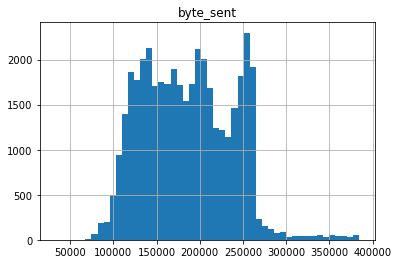

device_type live_tv_id  request_url request_method  \
1571935         1.0         -1     11016334       HTTP/1.1   
1571936         1.0         -1     11016334       HTTP/1.1   
1571937         1.0         -1     11016334       HTTP/1.1   
1571938         1.0         -1     11016334       HTTP/1.1   
1571939         1.0         -1     11016334       HTTP/1.1   
1571940         1.0         -1     11016334       HTTP/1.1   
1571941         1.0         -1     11016334       HTTP/1.1   
1571942         1.0         -1     11016334       HTTP/1.1   
1571943         1.0         -1     11016334       HTTP/1.1   
1571944         1.0         -1     11016334       HTTP/1.1   
1571945         1.0         -1     11016334       HTTP/1.1   
1571946         1.0         -1     11016334       HTTP/1.1   
1571947         1.0         -1     11016334       HTTP/1.1   
1571948         1.0         -1     11016334       HTTP/1.1   
1571949         1.0         -1     11016334       HTTP/1.1   
1571950         1.0         -1     11016334       HTTP/1.1   
1571951         1.0         -1     11016334       HTTP/1.1   
1571952         1.0         -1     11016334       HTTP/1.1   
1571953         1.0         -1     11016334       HTTP/1.1   
1571954         1.0         -1     11016334       HTTP/1.1   
1571955         1.0         -1     11016334       HTTP/1.1   
1571956         1.0         -1     11016334       HTTP/1.1   
1571957         1.0         -1     11016334       HTTP/1.1   
1571958         1.0         -1     11016334       HTTP/1.1   
1571959         1.0         -1     11016334       HTTP/1.1   
1571960         1.0         -1     11016334       HTTP/1.1   
1571961         1.0         -1     11016334       HTTP/1.1   
1571962         1.0         -1     11016334       HTTP/1.1   
1571963         1.0         -1     11016334       HTTP/1.1   
1571964         1.0         -1     11016334       HTTP/1.1   
1571965         1.0         -1     11016334       HTTP/1.1   
1571966         1.0         -1     11016334       HTTP/1.1   
1571967         1.0         -1     11016334       HTTP/1.1   
1571968         1.0         -1     11016334       HTTP/1.1   
1571969         1.0         -1     11016334       HTTP/1.1   
1571970         1.0         -1     11016334       HTTP/1.1   
1571971         1.0         -1     11016334       HTTP/1.1   
1571972         1.0         -1     11016334       HTTP/1.1   
1571973         1.0         -1     11016334       HTTP/1.1   
1571974         1.0         -1     11016334       HTTP/1.1   
1571975         1.0         -1     11016334       HTTP/1.1   
1571976         1.0         -1     11016334       HTTP/1.1   
1571977         1.0         -1     11016334       HTTP/1.1   
1571978         1.0         -1     11016334       HTTP/1.1   
1571979         1.0         -1     11016334       HTTP/1.1   
1571980         1.0         -1     11016334       HTTP/1.1   
1571981         1.0         -1     11016334       HTTP/1.1   
1571982         1.0         -1     11016334       HTTP/1.1   
1571983         1.0         -1     11016334       HTTP/1.1   
1571984         1.0         -1     11016334       HTTP/1.1   
1571985         1.0         -1     11016334       HTTP/1.1   
1571986         1.0         -1     11016334       HTTP/1.1   
1571987         1.0         -1     11016334       HTTP/1.1   
1571988         1.0         -1     11016334       HTTP/1.1   
1571989         1.0         -1     11016334       HTTP/1.1   
1571990         1.0         -1     11016334       HTTP/1.1   
1571991         1.0         -1     11016334       HTTP/1.1   
1571992         1.0         -1     11016334       HTTP/1.1   
1571993         1.0         -1     11016334       HTTP/1.1   
1571994         1.0         -1     11016334       HTTP/1.1   
1572001         1.0         -1     11016334       HTTP/1.1   
1572004         1.0         -1     11016334       HTTP/1.1   
1572005         1.0         -1     11016334       HTTP/1.1   
1572006         1.0         -1     11016

4 ----- 708963 ---------------------------------------------------------------------------------
byte_sent


request_url  byte_sent  count  Occur
88957     74647235       1734     82   1199
88958     74647235      13184     16   1199
88959     74647235      83017      3   1199
88960     74647235      85897      3   1199
88961     74647235      85898      1   1199
88962     74647235     409897      1   1199
88963     74647235     411337      1   1199
88964     74647235     421417      1   1199
88965     74647235     424297      1   1199
88966     74647235     428617      1   1199
88967     74647235     430057      4   1199
88968     74647235     432937      1   1199
88969     74647235     437251      1   1199
88970     74647235     437257     43   1199
88971     74647235     437258      1   1199
88972     74647235     438697     12   1199
88973     74647235     438698      1   1199
88974     74647235     444451      1   1199
88975     74647235     444457     11   1199
88976     74647235     444458      1   1199

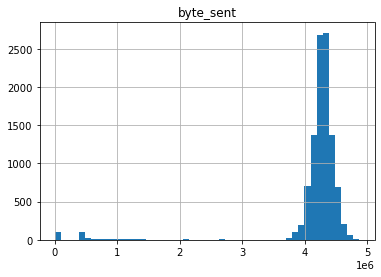

Empty DataFrame
Columns: [device_type, live_tv_id, request_url, request_method, time_received, user_loc, byte_sent, vod_encoding, time_to_serve, content_type, maxage, session_id, method, response_status, user_id, host_id, vod_id, devicebrand, statuscode, user_agent, request_header]
Index: []

12 ----- 858700 ---------------------------------------------------------------------------------
byte_sent


request_url  byte_sent  count  Occur
196650     54274620     217982      1    125
196651     54274620     227102      1    125
196652     54274620     232862      1    125
196653     54274620     241501      1    125
196654     54274620     250141      2    125
196655     54274620     251582      1    125
196656     54274620     254461      1    125
196657     54274620     260222      1    125
196658     54274620     265582      1    125
196659     54274620     267422      1    125
196660     54274620     269782      1    125
196661     54274620     270301      1    125
196662     54274620     284702      1    125
196663     54274620     289022      1    125
196664     54274620     291902      1    125
196665     54274620     296222      1    125
196666     54274620     304782      1    125
196667     54274620     306302      1    125
196668     54274620     313502      1    125
196669     54274620     316382      1    125

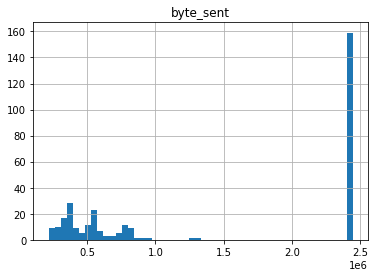

device_type live_tv_id  request_url request_method  \
838558         0.0         -1     74484359       HTTP/1.1   
838645         0.0         -1     54274620       HTTP/1.1   
838643         0.0         -1     54274620       HTTP/1.1   
838668         0.0         -1     54274744       HTTP/1.1   
838727         0.0         -1     54274620       HTTP/1.1   
838730         0.0         -1     54274620       HTTP/1.1   
838745         0.0         -1     54274744       HTTP/1.1   
838822         0.0         -1     55346825       HTTP/1.1   
838827         0.0         -1     55346825       HTTP/1.1   
838840         0.0         -1     74484473       HTTP/1.1   
838886         0.0         -1     54275699       HTTP/1.1   
838906         0.0         -1     54275813       HTTP/1.1   
838953         0.0         -1     55348083       HTTP/1.1   
838971         0.0         -1     55350544       HTTP/1.1   
838975         0.0         -1     54275699       HTTP/1.1   
838988         0.0         -1     54280350       HTTP/1.1   
838994         0.0         -1     54280425       HTTP/1.1   
838999         0.0         -1     54275813       HTTP/1.1   
839030         0.0         -1     55361608       HTTP/1.1   
839031         0.0         -1     55360248       HTTP/1.1   
839036         0.0         -1     55358831       HTTP/1.1   
839039         0.0         -1     55364459       HTTP/1.1   
839049         0.0         -1     55363026       HTTP/1.1   
839051         0.0         -1     55365818       HTTP/1.1   
839055         0.0         -1     55368483       HTTP/1.1   
839056         0.0         -1     55367083       HTTP/1.1   
839068         0.0         -1     55371147       HTTP/1.1   
839085         0.0         -1     54280350       HTTP/1.1   
839098         0.0         -1     55375491       HTTP/1.1   
839108         0.0         -1     57353706       HTTP/1.1   
839105         0.0         -1     57355002       HTTP/1.1   
839122         0.0         -1     54280425       HTTP/1.1   
839136         0.0         -1     54280963       HTTP/1.1   
839166         0.0         -1     74484483       HTTP/1.1   
839173         0.0         -1     54281133       HTTP/1.1   
839278         0.0         -1     54280963       HTTP/1.1   
839342         0.0         -1     54281133       HTTP/1.1   
840191         0.0         -1     74484548       HTTP/1.1   
840268         0.0         -1     74485123       HTTP/1.1   
840350         0.0         -1     74485113       HTTP/1.1   
840406         0.0         -1     74484809       HTTP/1.1   
840434         0.0         -1      2878669       HTTP/1.1   
840438         0.0         -1      2878669       HTTP/1.1   
840541         0.0         -1      2879103       HTTP/1.1   
840693         0.0         -1     74484825       HTTP/1.1   
840865         0.0         -1      2886810       HTTP/1.1   
841082         0.0         -1      2902993       HTTP/1.1   
841131         0.0         -1      2909068       HTTP/1.1   
841142         1.0         -1     14073701       HTTP/1.1   
841276         0.0         -1      2916421       HTTP/1.1   
841284         0.0         -1      2924260       HTTP/1.1   
841291         0.0         -1      2921548       HTTP/1.1   
841292         0.0         -1      2918752       HTTP/1.1   
841312         0.0         -1      2930033       HTTP/1.1   
841313         0.0         -1      2932761       HTTP/1.1   
841370         0.0         -1      2938730       HTTP/1.1   
841381         0.0         -1      2936369       HTTP/1.1   
841402         0.0         -1      2941531       HTTP/1.1   
841570         0.0         -1      2948991       HTTP/1.1   
841589         0.0         -1     22327184       HTTP/1.1   
841595         0.0         -1     22316782       HTTP/1.1   
841596         0.0         -1     22321970       HTTP/1.1   
841616         0.0         -1     18303108       HTTP/1.1   
841747         0.0         -1     18303189       HTTP/1.1   
841755         0.0         -1     22340958

In [181]:
dfNbyte= {}
dfPerc={}
for key in ['7','2','4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    dfNbyte[key]= getN_connection(dfDict[key], 'byte_sent', 2)
    dfPerc[key]= np.round(dfNbyte[key].shape[0]/dfDict[key].shape[0] *100,2)
    display(dfNbyte[key][dfNbyte[key]['statuscode']==200].tail(100))

In [124]:
for key in ['7','2','4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    print(dfNbyte[key].groupby(['content_type', 'statuscode', 'maxage', 'response_status']).size())

7 ----- 561706 ---------------------------------------------------------------------------------
content_type  statuscode  maxage  response_status
text/xml      200         1.0     tcp_miss            539
                          2.0     tcp_miss            332
              206         1.0     tcp_hit              79
                                  tcp_miss           3138
                          2.0     tcp_hit              40
                                  tcp_miss           1581
video/mp4     200         60.0    tcp_hit              32
                                  tcp_miss            385
                          120.0   tcp_hit               3
                                  tcp_miss             50
                          3600.0  tcp_hit               2
                                  tcp_miss            160
              206         60.0    tcp_hit             915
                                  tcp_miss           2745
                          120.0   tcp_hit

https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Range 

https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Content-Range

https://ottverse.com/structure-of-an-mpeg-dash-mpd/

https://en.wikipedia.org/wiki/M3U

## check delay

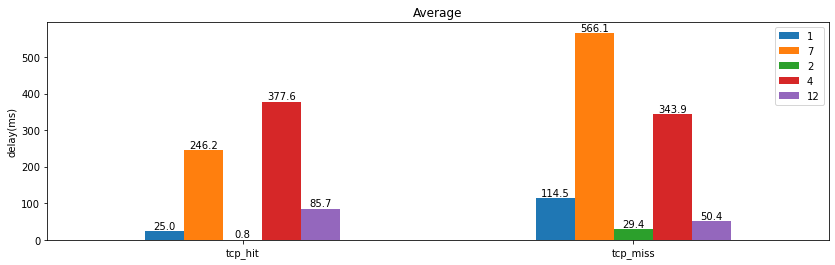

In [12]:
# mean()
dfBar=pd.DataFrame(index=['tcp_hit', 'tcp_miss'])
for key in dfDict:
    dfBar[key]= dfDict[key].groupby(['response_status'])['time_to_serve'].mean().values
ax= dfBar.multiply(1000).plot.bar(figsize=(14,4), ylabel='delay(ms)',rot=0, title='Average')
for container in ax.containers:
    ax.bar_label(container, fmt='%0.1f')

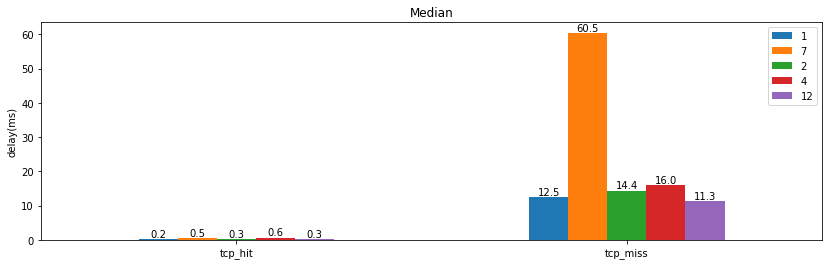

In [14]:
#median()
dfBar=pd.DataFrame(index=['tcp_hit', 'tcp_miss'])
for key in dfDict:
    dfBar[key]= dfDict[key].groupby(['response_status'])['time_to_serve'].median().values
ax= dfBar.multiply(1000).plot.bar(figsize=(14,4), ylabel='delay(ms)',rot=0, title='Median')
for container in ax.containers:
    ax.bar_label(container, fmt='%0.1f')

## Check features connection with hit/miss

In [24]:
for key in dfDict:
    print(key)
    get_HR(dfDict[key])

1
response OHR:  74.85730612620944  BHR:  72.1884272986117 #requests 5253379
7
response OHR:  5.489888521651448  BHR:  4.917649356114116 #requests 589083
2
response OHR:  90.80037960248885  BHR:  92.67732626153453 #requests 1567956
4
response OHR:  60.1795328123734  BHR:  61.636516280961615 #requests 715858
12
response OHR:  23.305252524079634  BHR:  22.882792097412334 #requests 861205


1
How is everything related to hit\miss


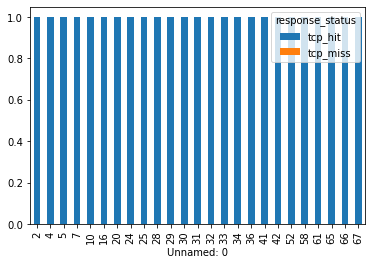

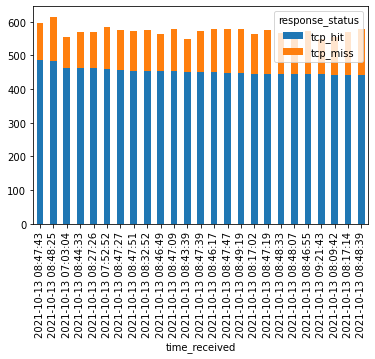

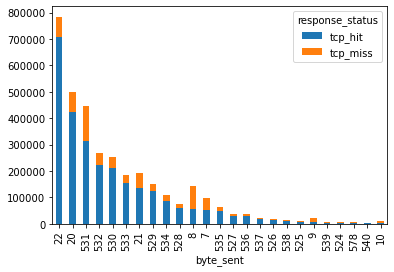

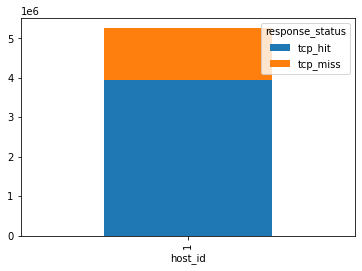

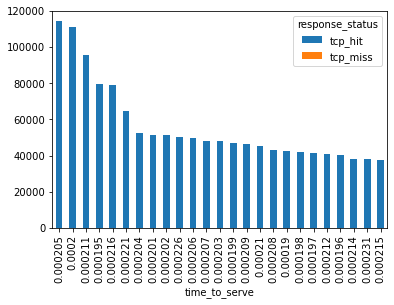

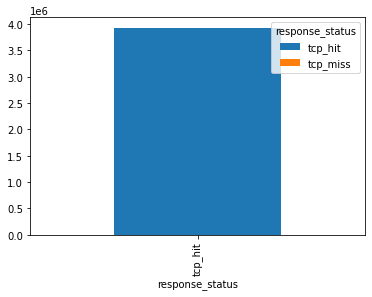

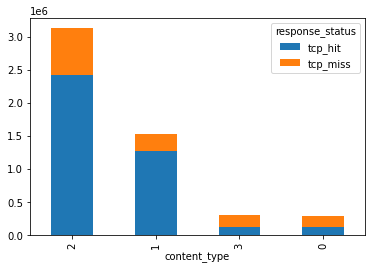

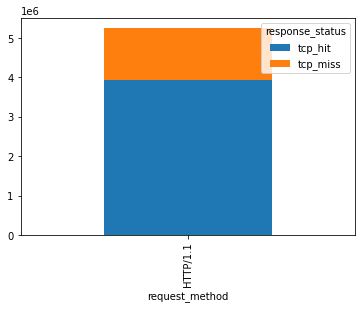

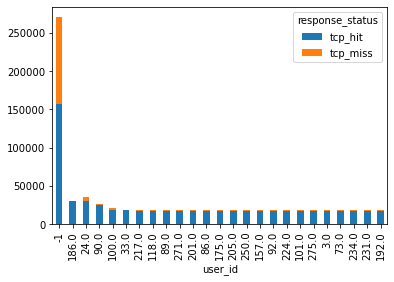

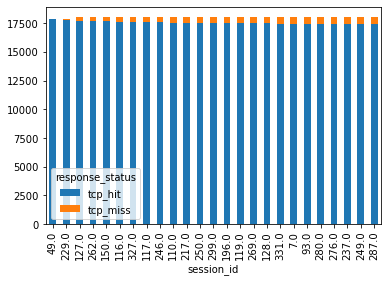

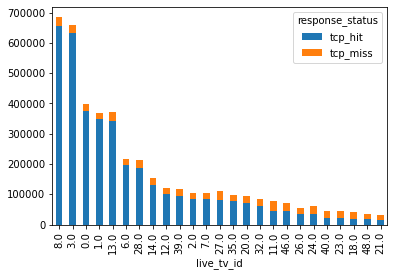

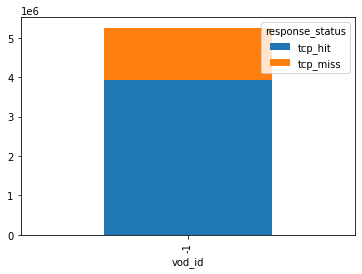

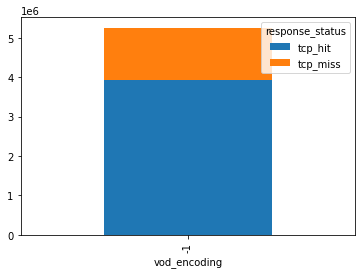

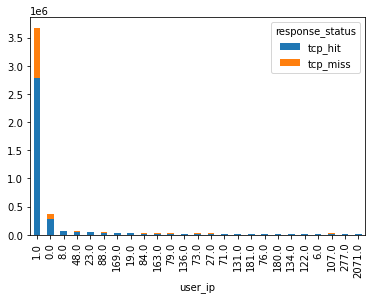

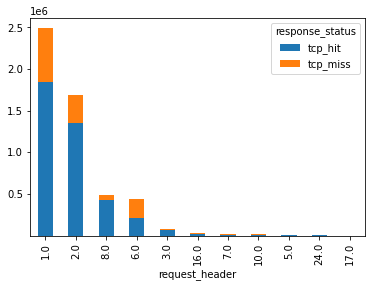

7
How is everything related to hit\miss


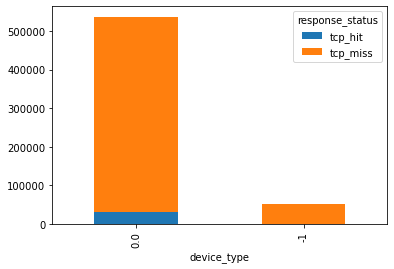

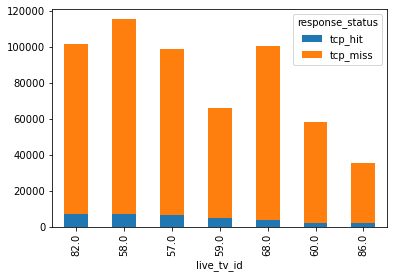

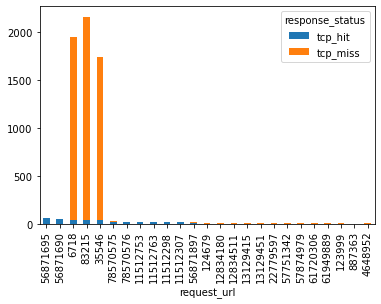

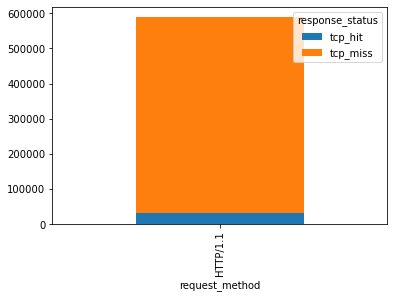

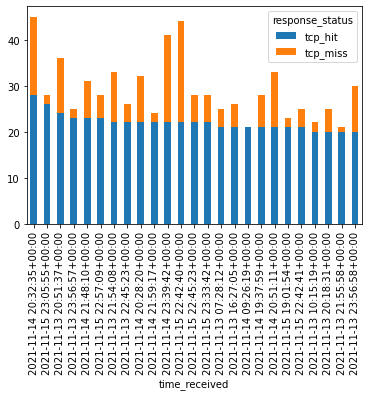

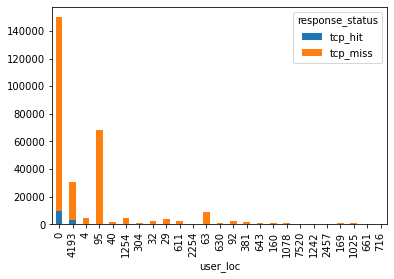

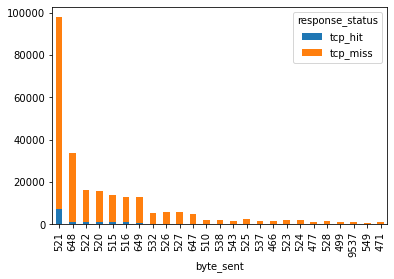

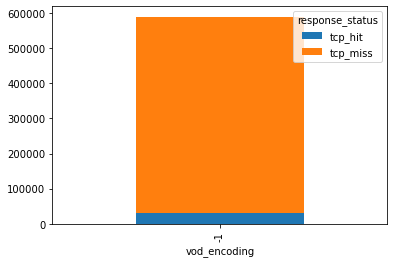

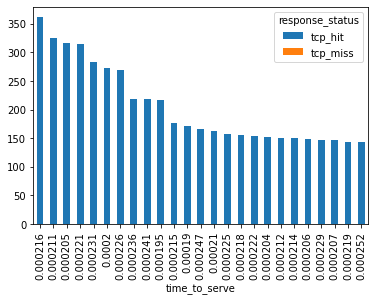

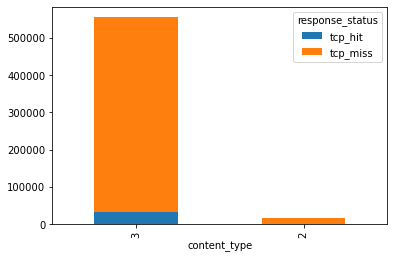

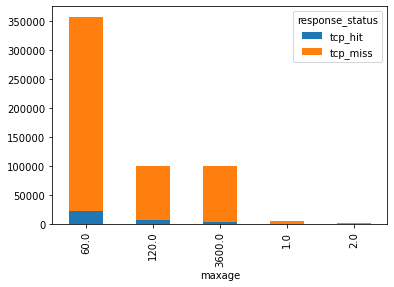

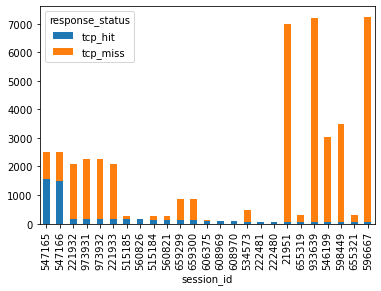

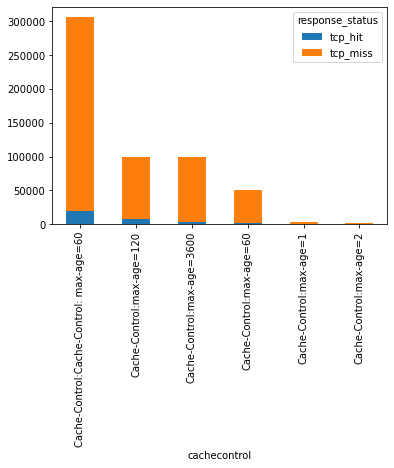

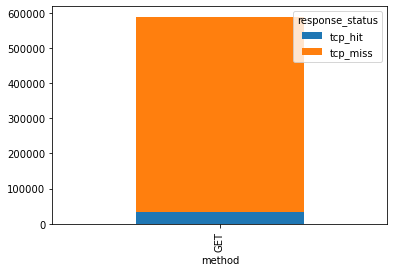

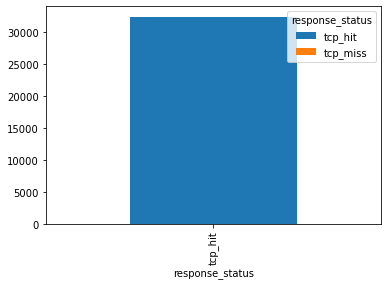

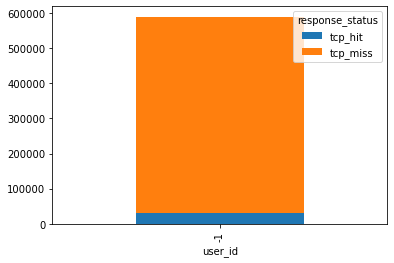

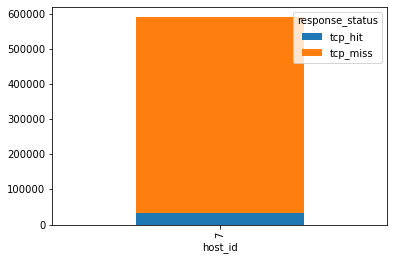

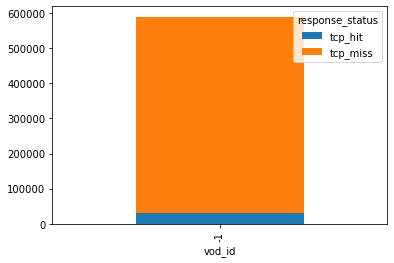

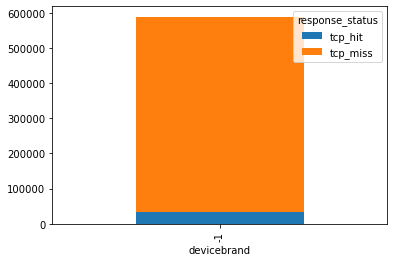

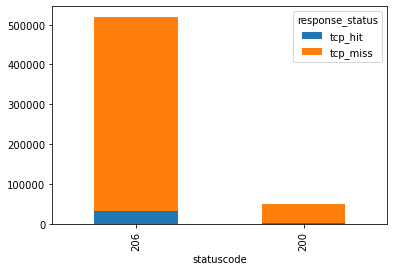

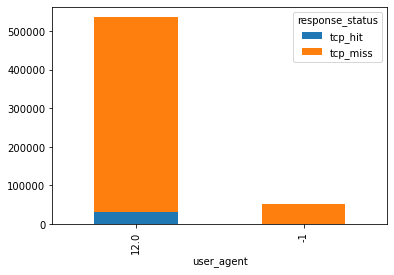

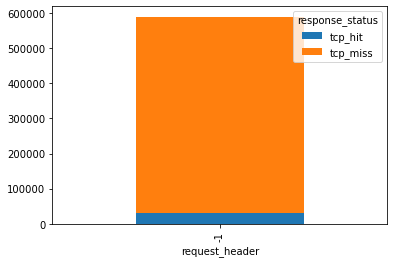

2
How is everything related to hit\miss


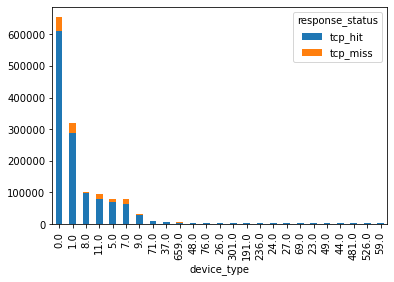

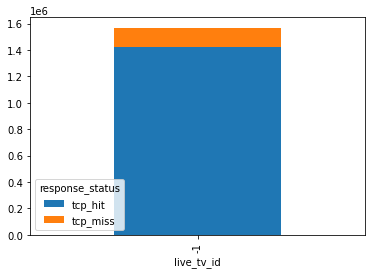

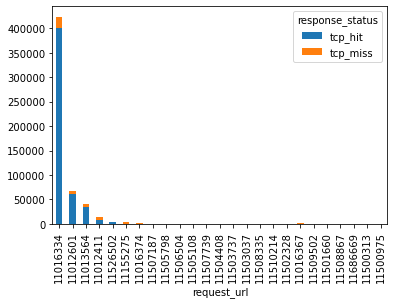

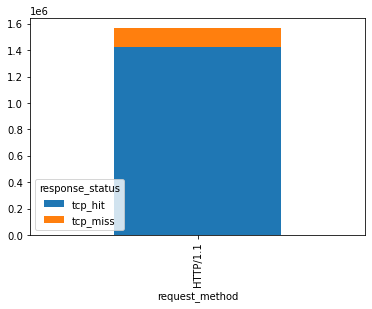

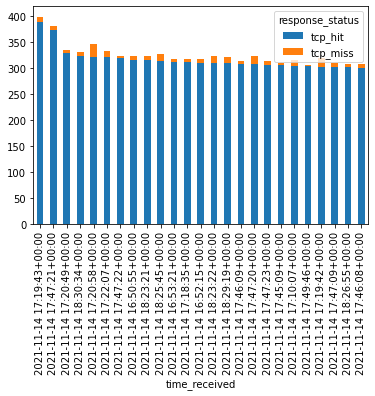

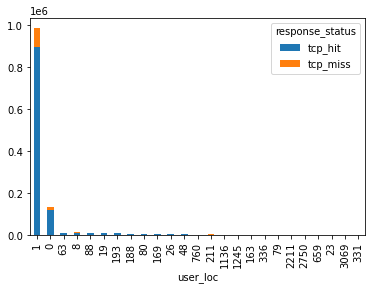

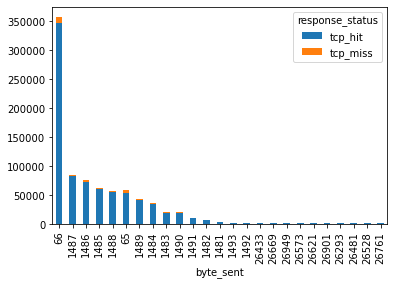

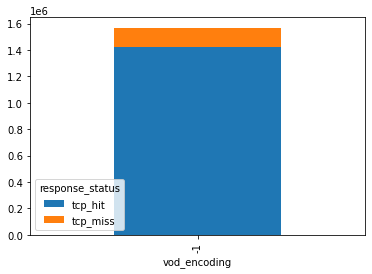

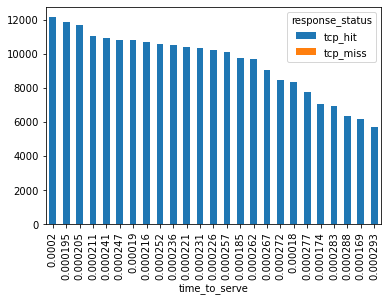

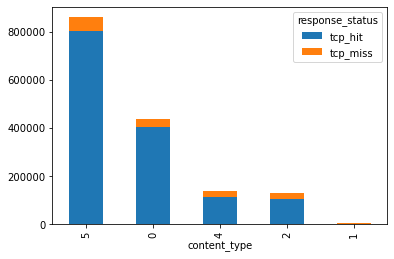

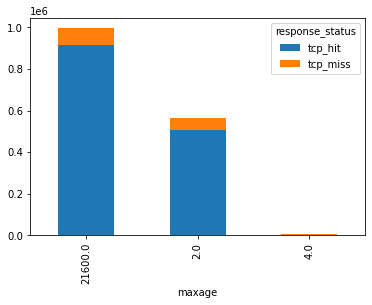

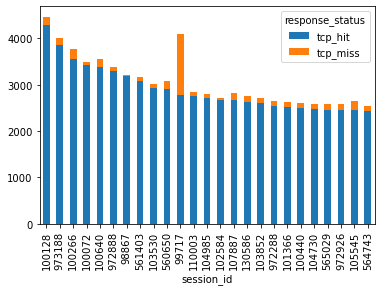

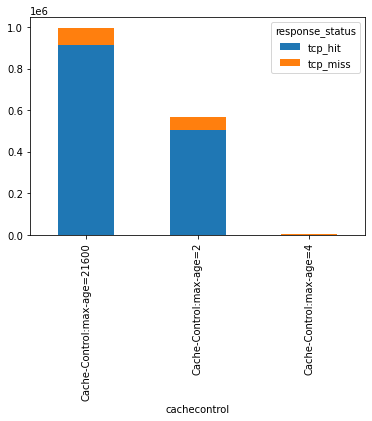

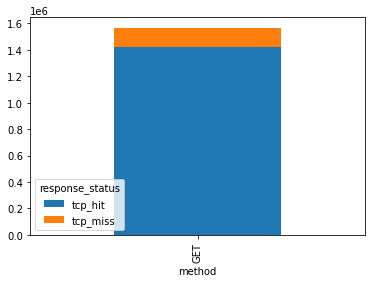

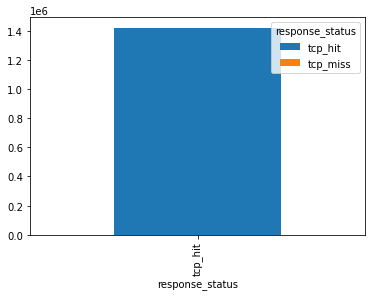

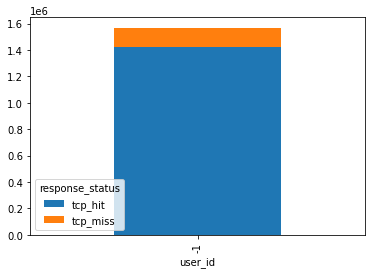

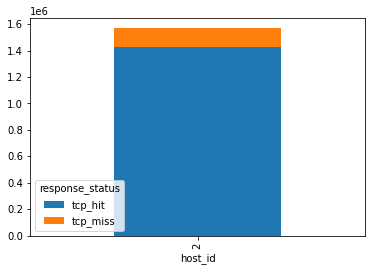

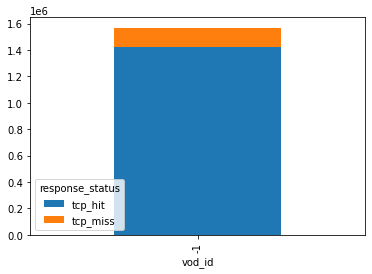

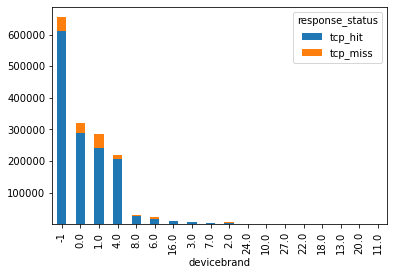

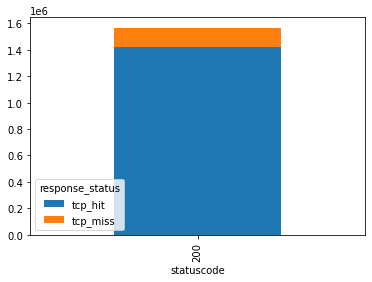

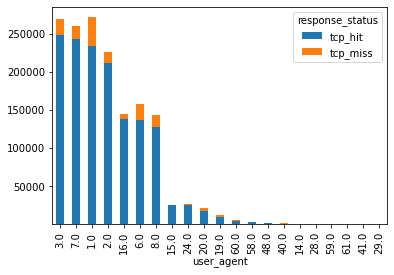

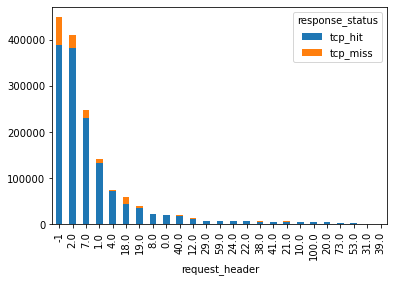

4
How is everything related to hit\miss


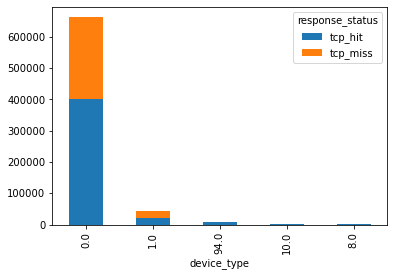

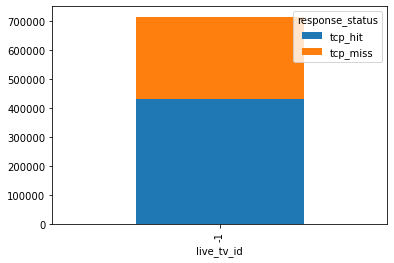

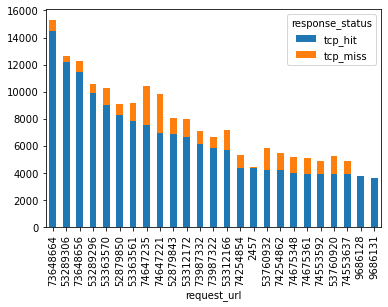

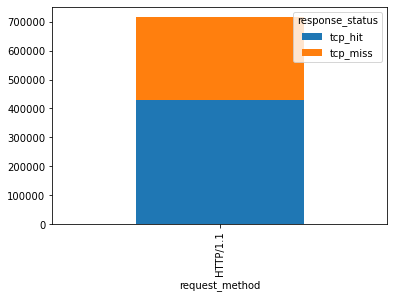

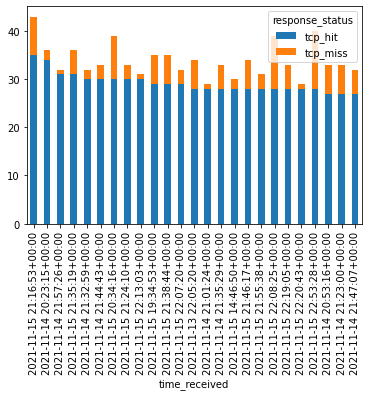

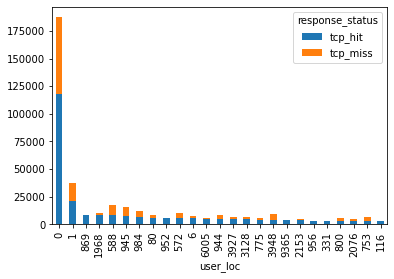

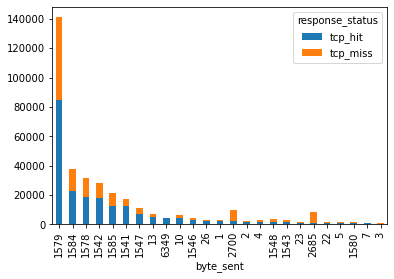

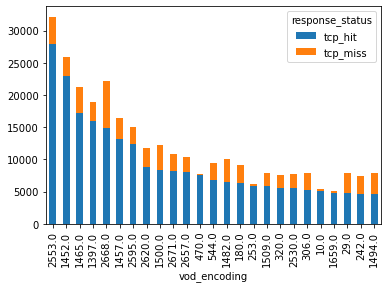

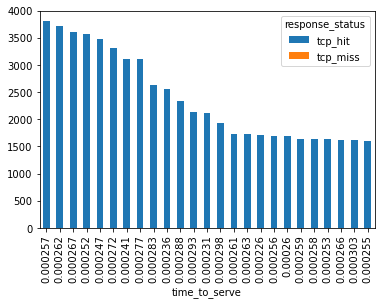

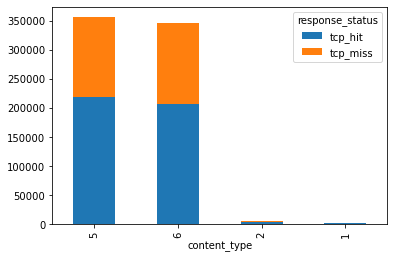

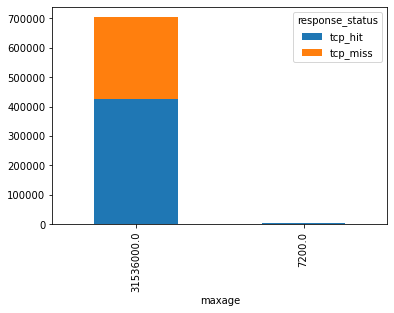

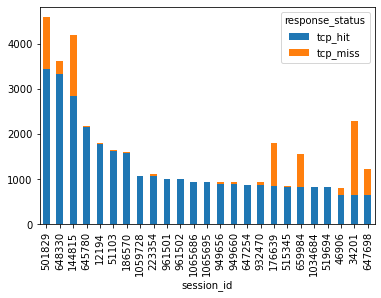

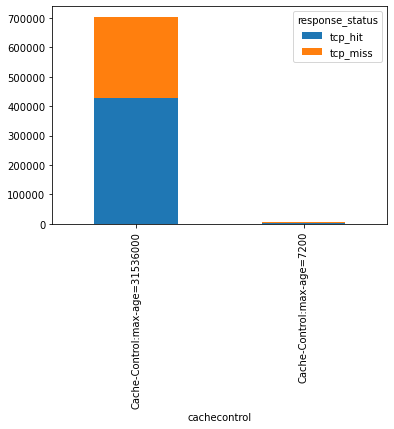

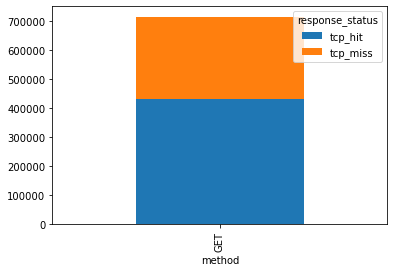

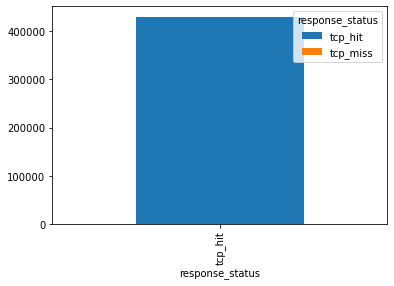

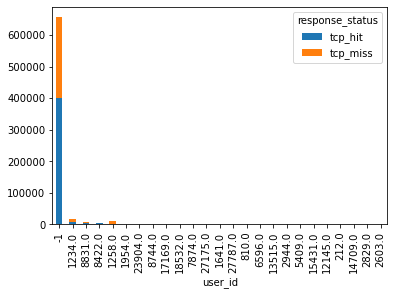

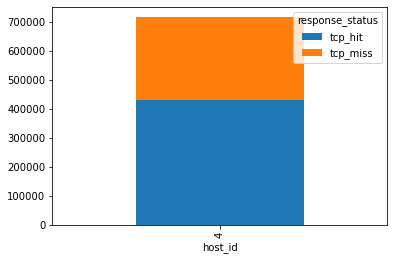

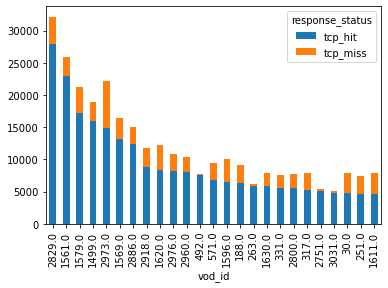

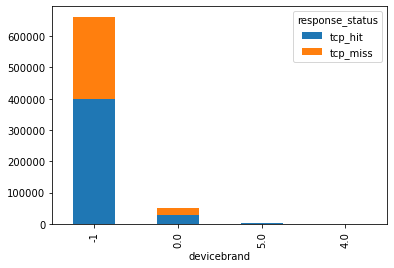

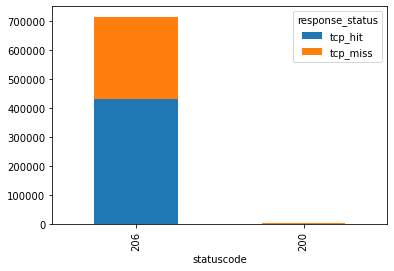

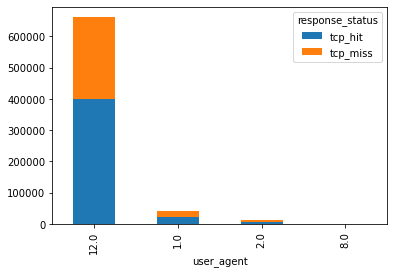

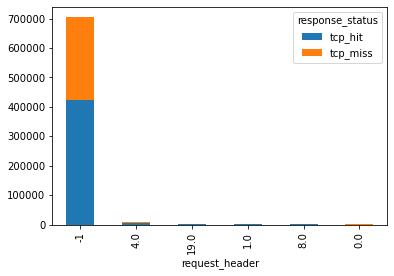

12
How is everything related to hit\miss


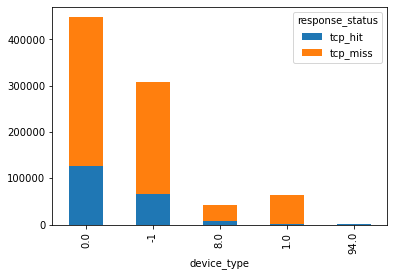

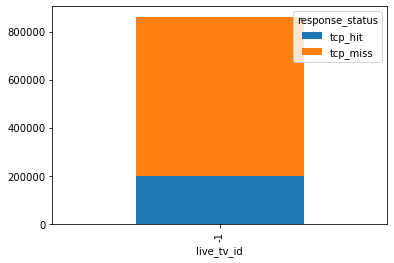

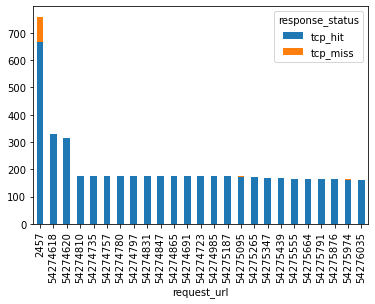

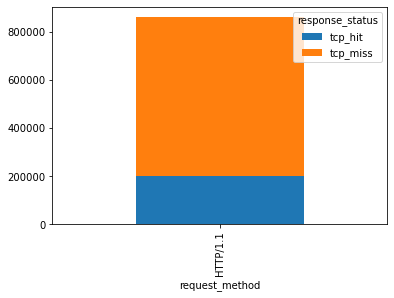

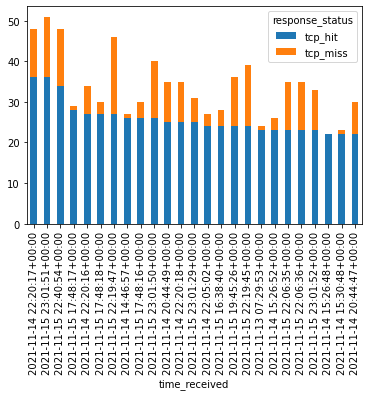

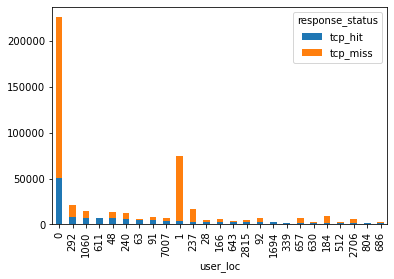

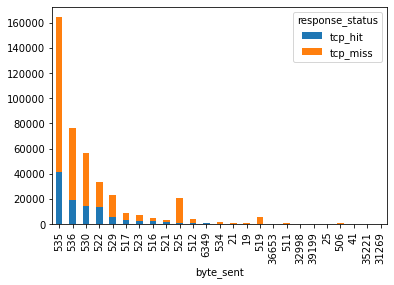

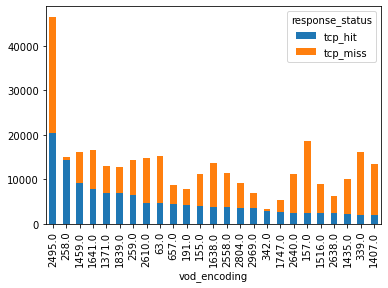

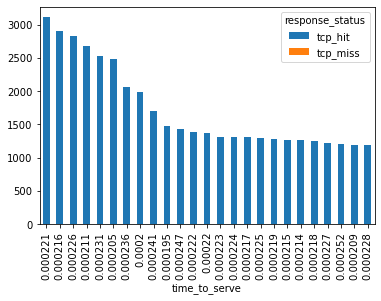

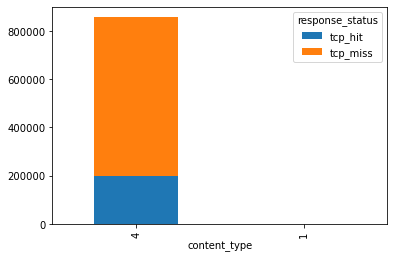

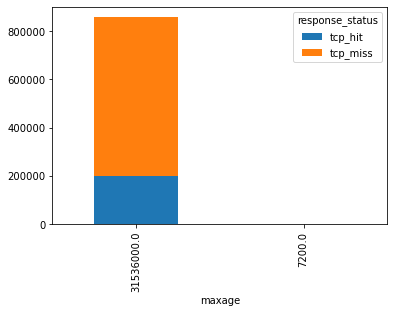

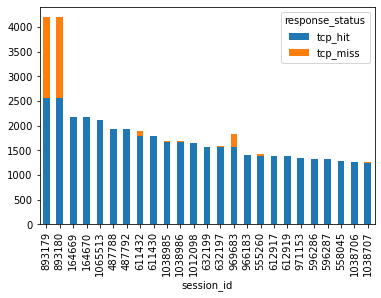

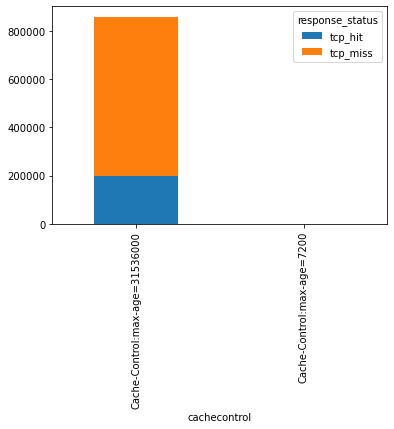

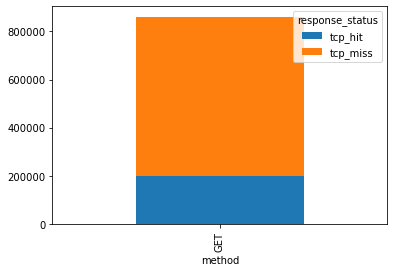

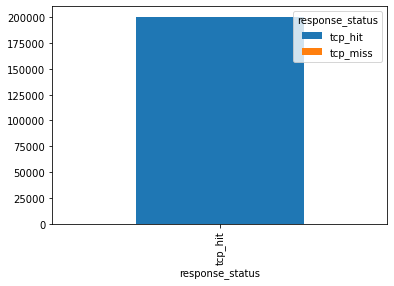

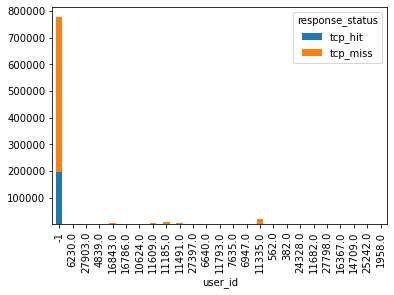

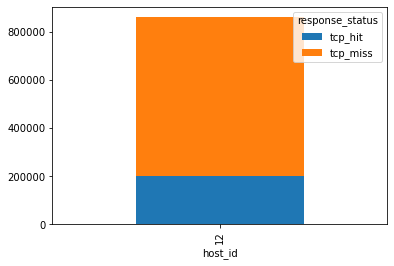

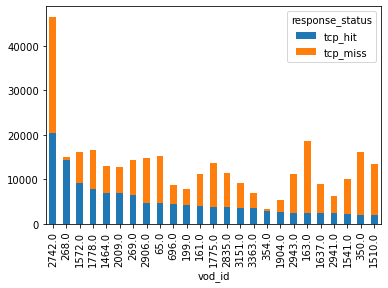

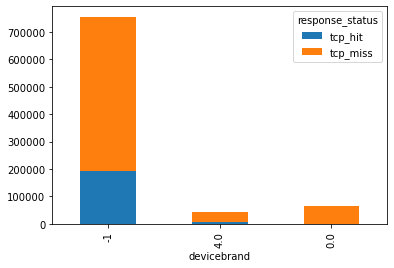

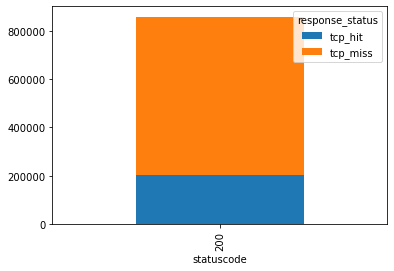

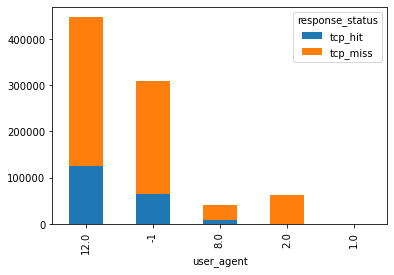

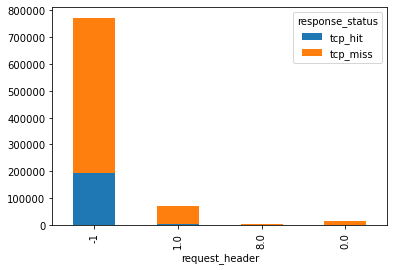

In [54]:
for key in dfDict:
    print(key)
    plotAll(dfDict[key])

We notice in new data that:
- most of the hits are when live-tv-id is nan- strange behavior
- new data has very few live-tv-id (7), not like old data
- no need to deeply preprocess content type, just encode it
- max age and Cache-Control:max-age seems similar, need to check
- What to do for hosts, they have different hit/miss behaviour
- max age null means don't cache (always miss)
- 206 Partial Content

## request size

1
7
2
4
12


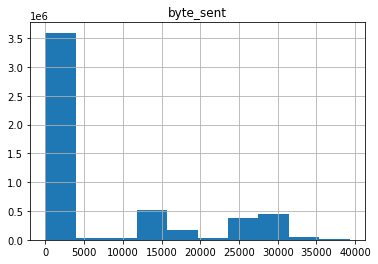

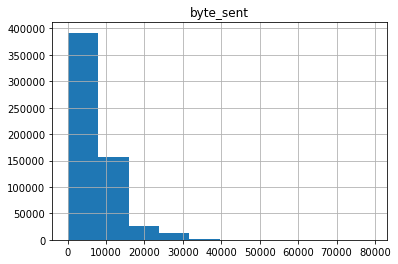

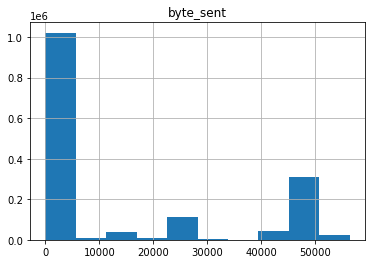

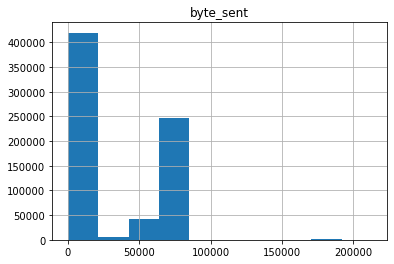

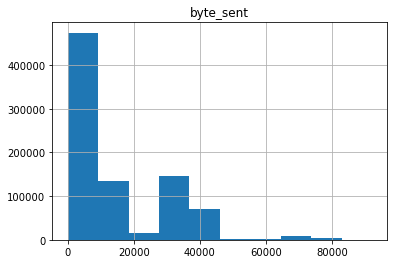

In [51]:
for key in dfDict:
    print(key)
    dfDict[key].hist("byte_sent")

# Preparation and preprocessing

## content_type

In [9]:
for key in dfDict:
    dfDict[key]= encodeCol(dfDict[key], 'content_type')

# Caching

In [17]:
object_id_setM1= ['byte_sent', 'content_type', 'live_tv_id', 'vod_id'] # method 1
object_id_setM2= ['byte_sent', 'request_url'] # method 2
dfDict2= dfDict.copy() # method 2
del dfDict2['1'] # we can't use request_url for old data

In [22]:
# method1
print("Method1")
for key in dfDict:
    print(key)
    getNumUnique(dfDict[key], object_id_setM1)
    get_HR(dfDict[key])
           
# method2
print("Method2")
for key in dfDict2:
    print(key)
    getNumUnique(dfDict2[key], object_id_setM2)

Method1
1
5253379 281269 94.64594121231306
response OHR:  74.85730612620944  BHR:  72.1884272986117 #requests 5253379
7
589083 59515 89.89700941972524
response OHR:  5.489888521651448  BHR:  4.917649356114116 #requests 589083
2
1567956 13516 99.13798601491368
response OHR:  90.80037960248885  BHR:  92.67732626153453 #requests 1567956
4
715858 84234 88.2331412095695
response OHR:  60.1795328123734  BHR:  61.636516280961615 #requests 715858
12
861205 255477 70.33493767453743
response OHR:  23.305252524079634  BHR:  22.882792097412334 #requests 861205
Method2
7
589083 470014 20.212601619805703
2
1567956 52656 96.64174249787621
4
715858 86690 87.89005640783508
12
861205 507386 41.0841785637566


## Intial cache +  add object id + prepare for algo + export df

In [10]:
# method1
for key in dfDict:
    print("host: ", key)
    dfIntial= getIntialCache(dfDict[key], object_id_setM1)
    df= addObjectId(dfDict[key], dfIntial, object_id_setM1)
    df_algo= perpareForAlgo(df)
    df_algo.to_csv('../../Algo/lrb-master/M1host'+ str(key)+'.tr', index = False, header=False, sep=' ')

host:  1
#requests: 5253379
#cached requests 49470
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
#/% of distinct objects: 281268 5.354039752319411


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0      49470      29488
1     1      49471      26232
2     2      49472      28808
3     3      49473         31
4     4      49474      31422

host:  7
#requests: 589083
#cached requests 619
0
100000
200000
300000
400000
500000
#/% of distinct objects: 59514 10.102820824909223


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0        619       5694
1     1        620        449
2     2        621       5521
3     3        622          2
4     4        623         30

host:  2
#requests: 1567956
#cached requests 1668
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
#/% of distinct objects: 13515 0.8619502077864429


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       1668         67
1     1       1668         67
2     2       1668         67
3     3       1668         67
4     4       1668         67

host:  4
#requests: 715858
#cached requests 14262
0
100000
200000
300000
400000
500000
600000
700000
#/% of distinct objects: 84233 11.766719097921655


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      54437
1     1          1       1295
2     2          2       1546
3     3          3          1
4     4          4          1

host:  12
#requests: 861205
#cached requests 7987
0
100000
200000
300000
400000
500000
600000
700000
800000
#/% of distinct objects: 255476 29.664946209090754


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      31037
1     1          1        530
2     2          2      41530
3     3          3        535
4     4          4      33120

In [17]:
# method2
for key in dfDict2:
    print("host: ", key)
    dfIntial= getIntialCache(dfDict[key], object_id_setM2)
    df= addObjectId( dfDict[key], dfIntial, object_id_setM2)
    df_algo= perpareForAlgo(df)
    df_algo.to_csv('../../Algo/lrb-master/M2host'+ str(key)+'.tr', index = False, header=False, sep=' ')

host:  7
#requests: 589083
#cached requests 4516
0
100000
200000
300000
400000
500000
#/% of distinct objects: 470013 79.78722862482876


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       4516       5694
1     1       4517        449
2     2       4518       5521
3     3       4519          2
4     4       4520         30

host:  2
#requests: 1567956
#cached requests 5230
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
#/% of distinct objects: 52655 3.358193724823911


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       5230         67
1     1       5230         67
2     2       5230         67
3     3       5230         67
4     4       5230         67

host:  4
#requests: 715858
#cached requests 14480
0
100000
200000
300000
400000
500000
600000
700000
#/% of distinct objects: 86689 12.109803899656077


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      54437
1     1          1       1295
2     2          2       1546
3     3          3          1
4     4          4          1

host:  12
#requests: 861205
#cached requests 15291
0
100000
200000
300000
400000
500000
600000
700000
800000
#/% of distinct objects: 507385 58.91570531987158


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      31037
1     1          1        530
2     2          2      41530
3     3          3        535
4     4          4      33120

## Run all algos for all hosts Don't Run

In [ ]:
from subprocess import PIPE, run, check_output
import os

def runAlgos(name, size, method):
    print(name, size, method)
    pwd= os.getcwd()
    algos= ["Random","Inf","Belady","RelaxedBelady","AdaptSize","LRU","ThLRU","LeCaR","UCB","LRB"]
    outf = open("../../DSL2/Results/"+ str(method) + str(name)+ "-" + str(size)+ ".json", "w+")
    outf.write("[")
    for algo in algos:
        os.system("docker rm $(docker ps -a -q  --filter ancestor=sunnyszy/webcachesim)")
        p = check_output(['docker', 'run', '-it', '-v', pwd+':/trace', 'sunnyszy/webcachesim', str(method) + str(name)+".tr", algo, str(size)])
        st=p.decode("utf-8")
        start= st.find("trace_file")
        end= st.find("segment_rss")
        outf.write(st[start-3:end-3])
        outf.write("}")
        if algo != algos[-1]:
            outf.write(",")
        print(algo+ " Done")
        
    outf.write("]") 


names= [1, 7,2,4,12]
sizes= range(int(1e8),int(2e9),int(3e8))
method= "M1host"

for name in names:
    for size in sizes:
        runAlgos(name, size, method)
    
# docker run -it -v ${PWD}:/trace sunnyszy/webcachesim host2.tr LRU 100000000 > LRU-v.txt



## Reading results after running

Host 1
response OHR:  74.85720638079898  BHR:  72.18869167610089 #requests 5253386
100000000


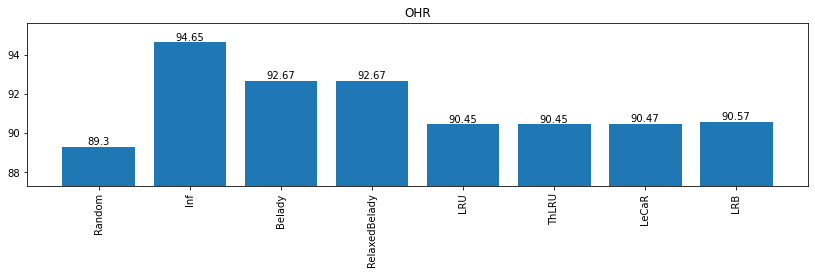

400000000


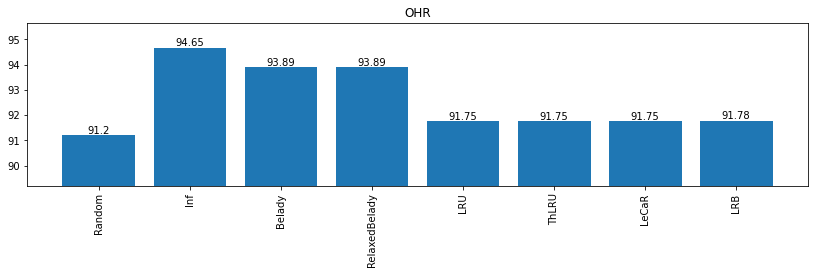

700000000


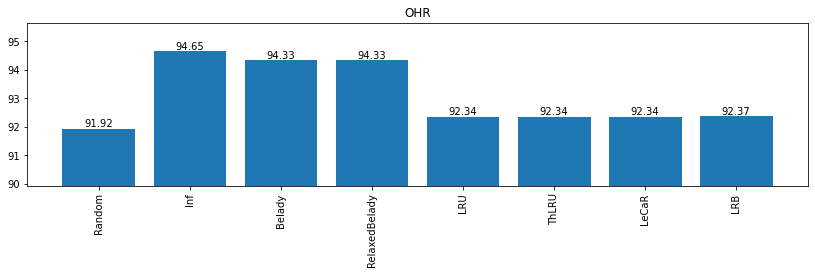

1000000000


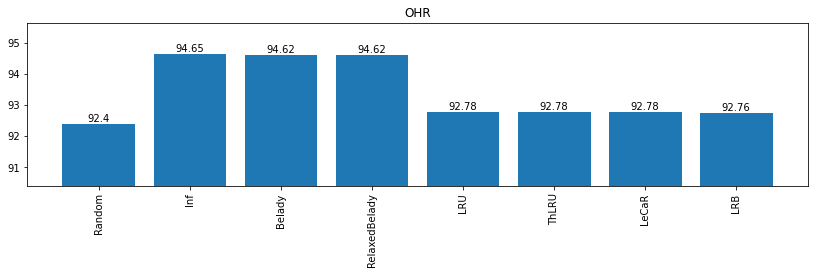

1300000000


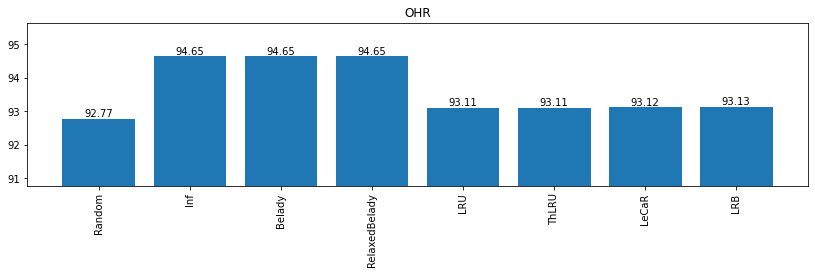

1600000000


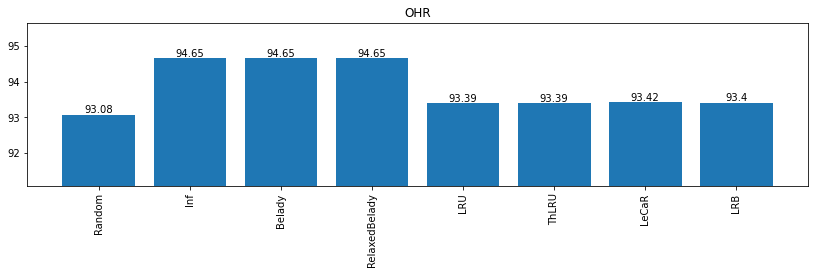

1900000000


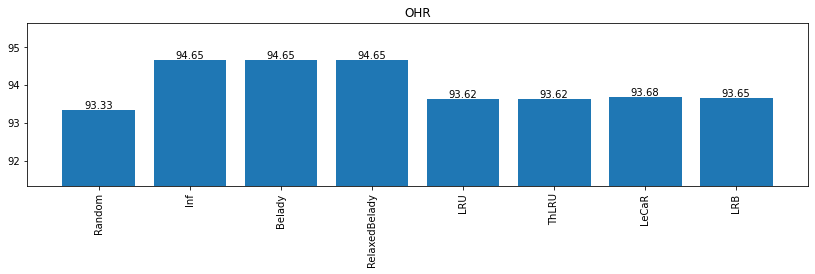

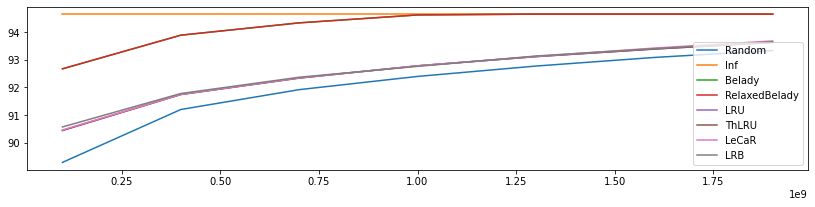

Host 7
response OHR:  5.484349085433067  BHR:  4.9176978507226154 #requests 589678
100000000


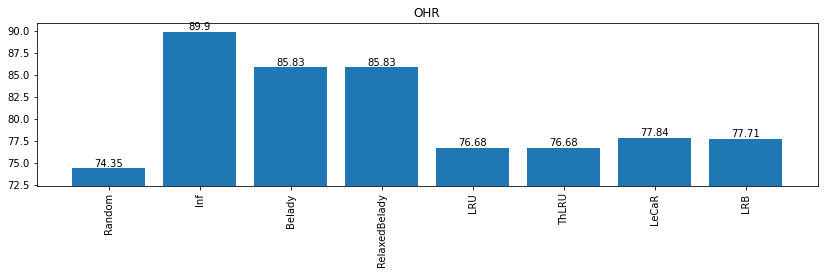

400000000


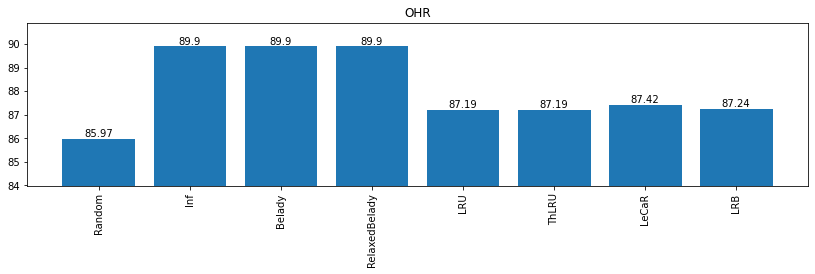

700000000


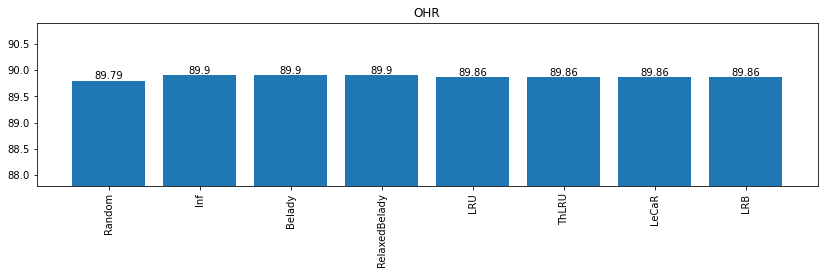

1000000000


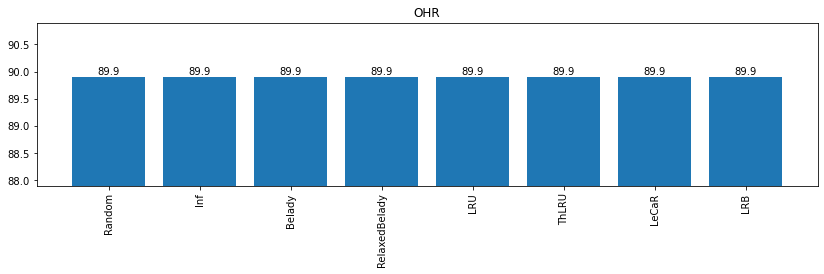

1300000000


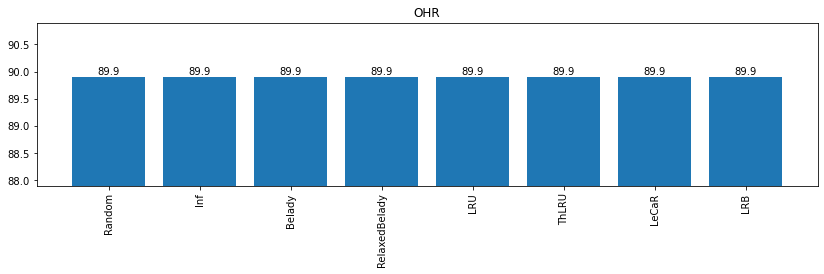

1600000000


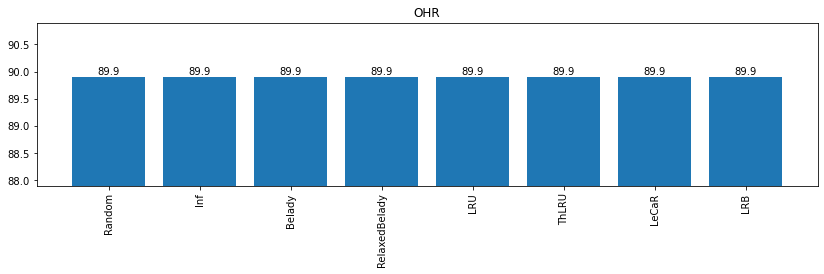

1900000000


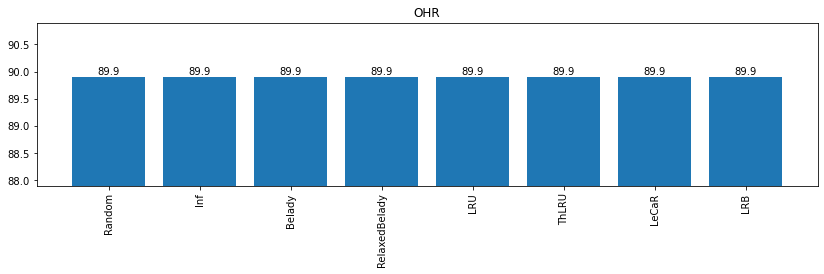

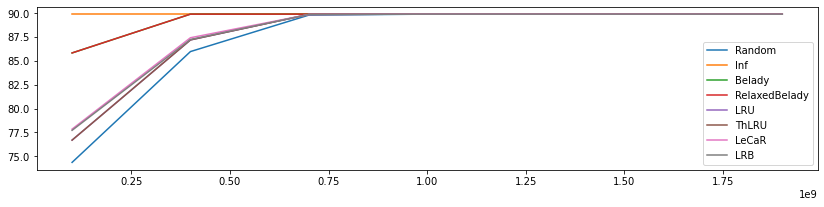

Host 2
response OHR:  90.56431662492692  BHR:  92.67721945227353 #requests 1572043
100000000


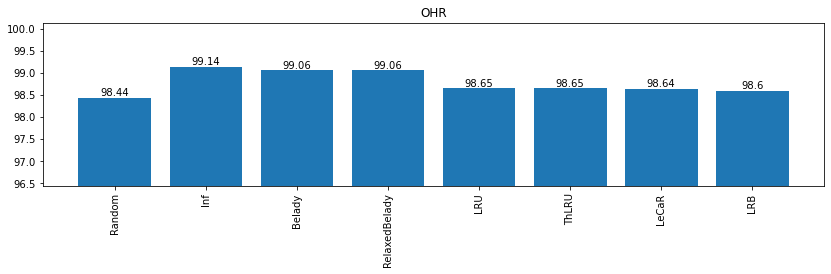

400000000


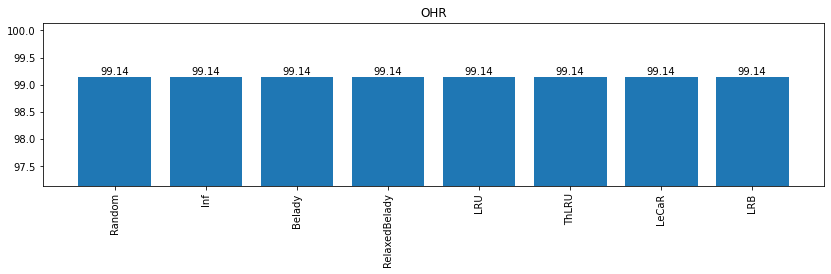

700000000


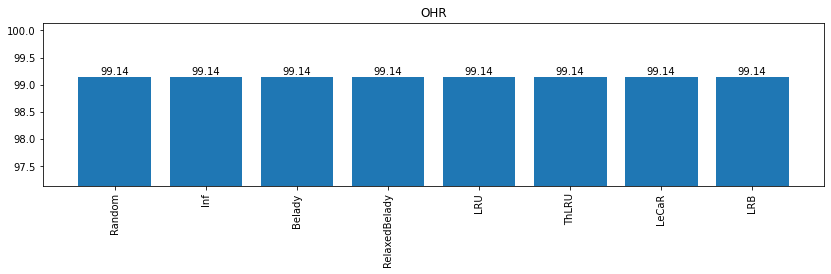

1000000000


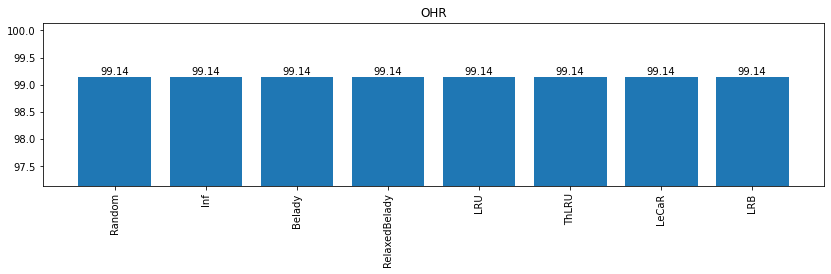

1300000000


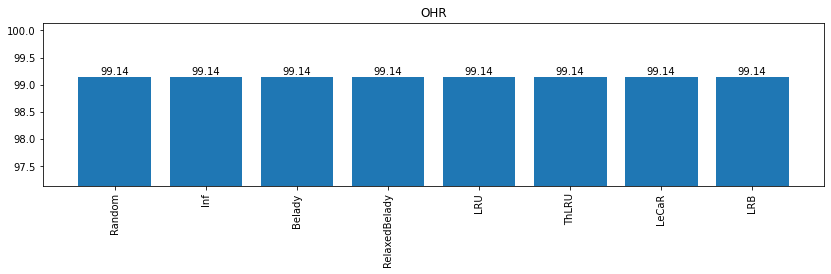

1600000000


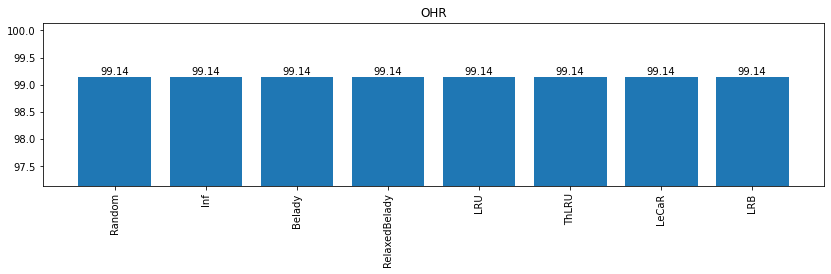

1900000000


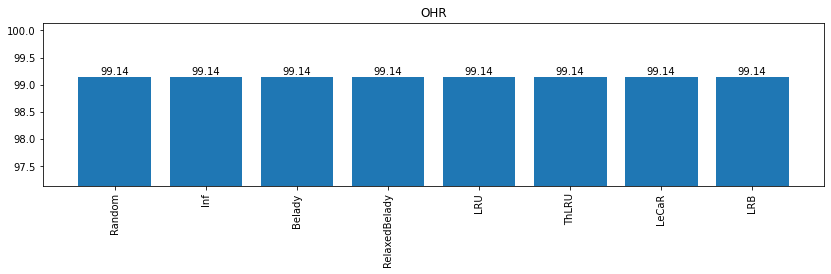

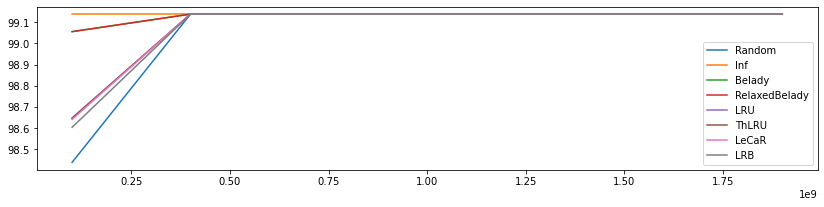

Host 4
response OHR:  60.1795328123734  BHR:  61.63648524199482 #requests 715858
100000000


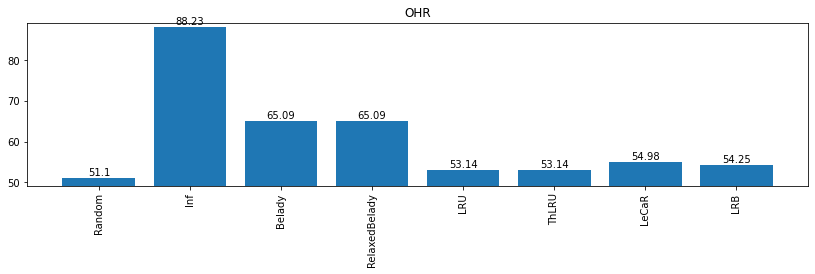

400000000


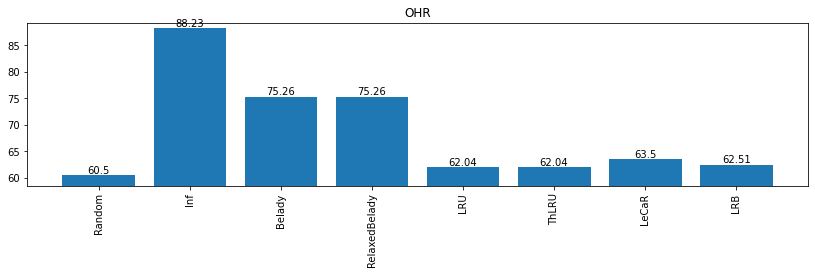

700000000


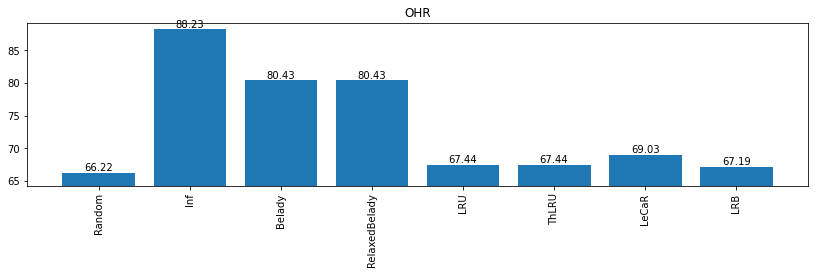

1000000000


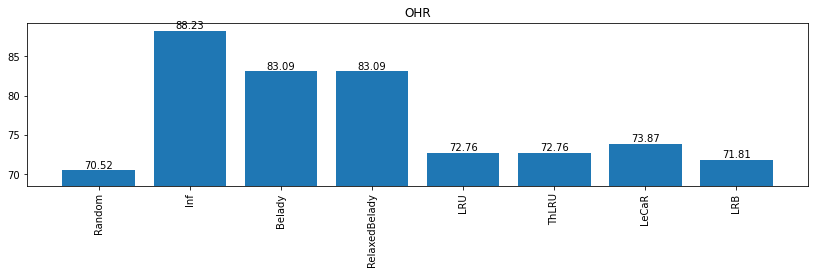

1300000000


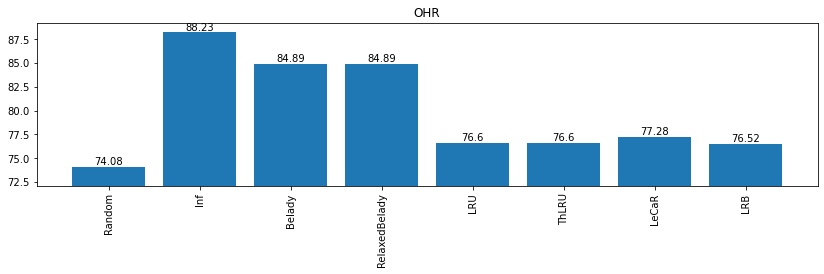

1600000000


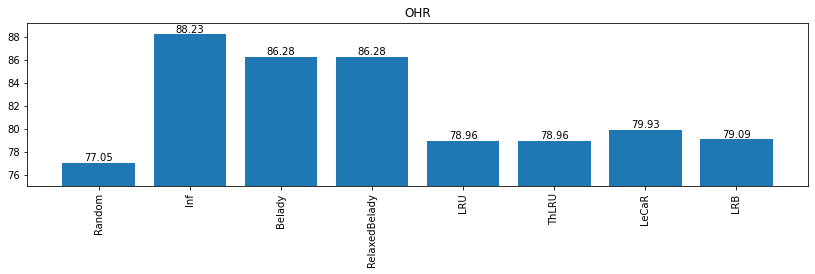

1900000000


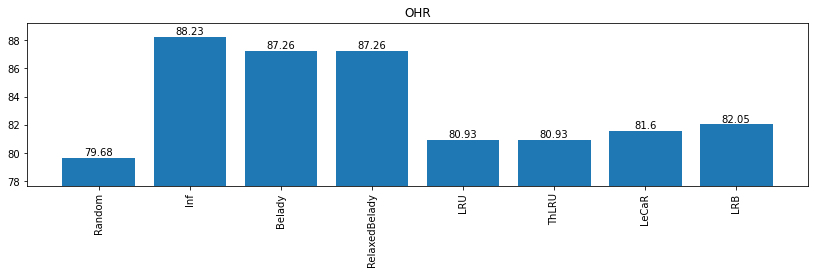

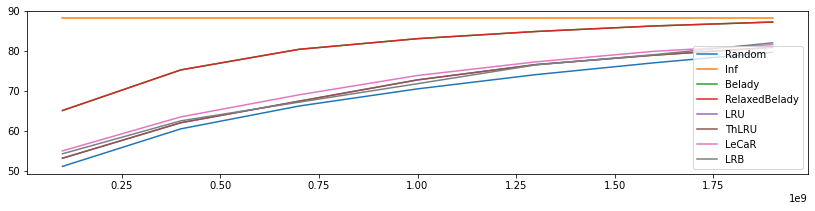

Host 12
response OHR:  23.305252524079634  BHR:  22.882814417081292 #requests 861205
100000000


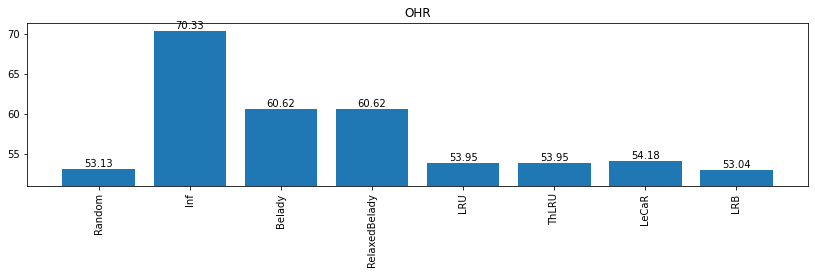

400000000


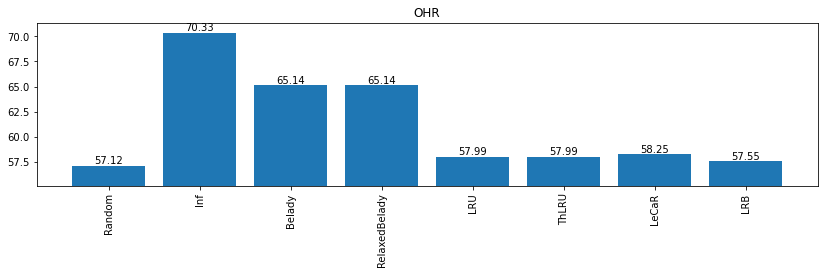

700000000


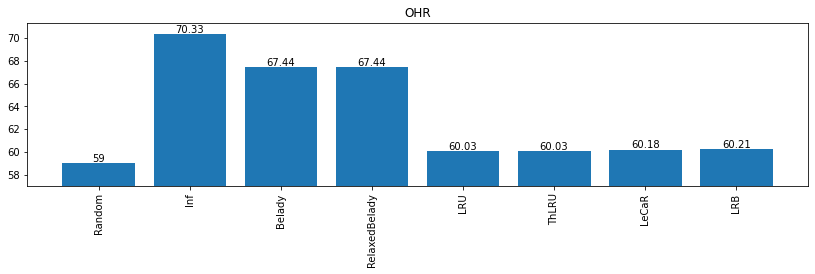

1000000000


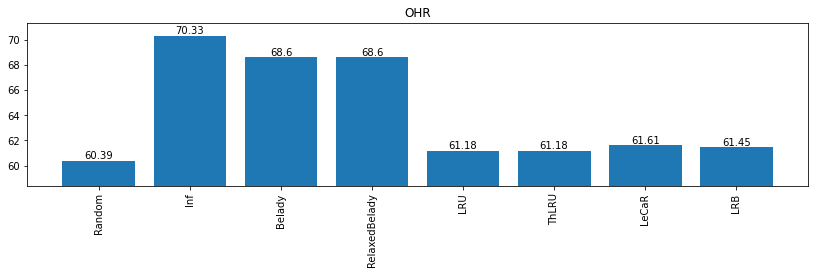

1300000000


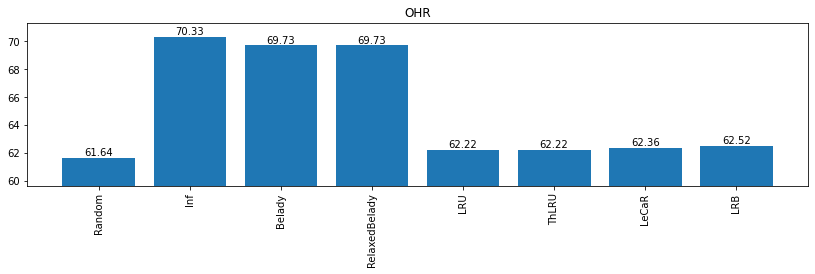

1600000000


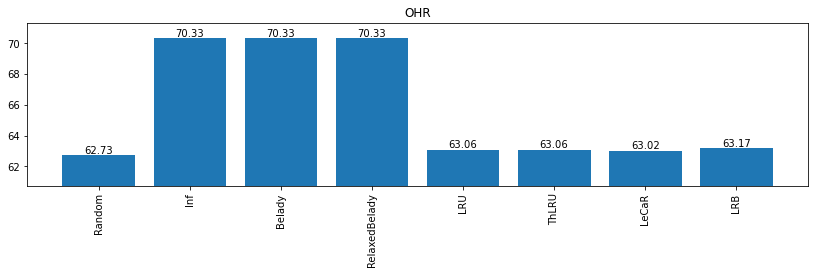

1900000000


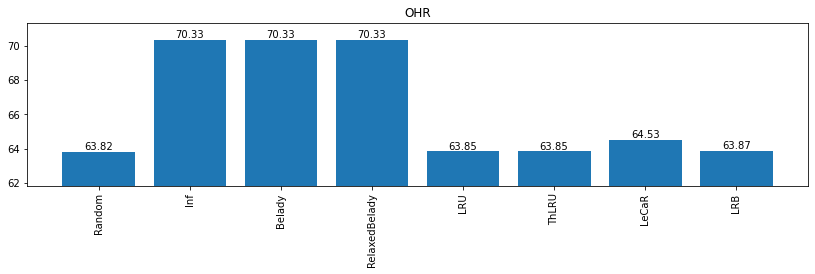

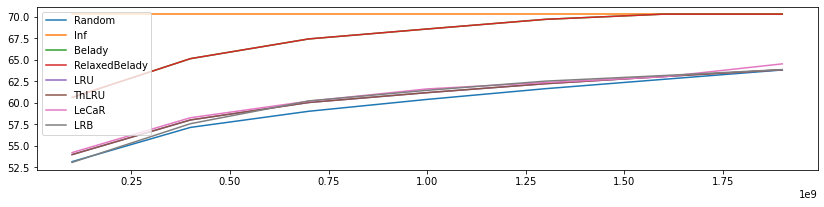

In [19]:
sizes= range(int(1e8),int(2e9),int(3e8))
algos= ["Random","Inf","Belady","RelaxedBelady","LRU","ThLRU","LeCaR","LRB"]
for key in dfDict:
    print("Host", key)
    OHRD={}
    for item in algos:
        OHRD[item]=[]
    get_HR(dfDict[key])
    for size in sizes: 
        print(size)
        f = open('../Results/M1host'+ str(key)+ "-" + str(size)+ '.json')
        data = json.load(f)
        OHR={}
        BHR={}
        for item in data:
            if item['cache_type']!="AdaptSize" and item['cache_type']!="UCB":
                OHR[item['cache_type']], BHR[item['cache_type']]=   getHitRatesAlgo(item)
                OHRD[item['cache_type']].append(OHR[item['cache_type']])
        pltDict(OHR, "OHR")
        #pltDict(BHR, "BHR")
    figure(figsize=(14,3))
    for keyp in OHRD:
        plt.plot(sizes, OHRD[keyp])
    plt.legend(algos)
    plt.show()

In [167]:
sizes= range(int(1e8),int(2e9),int(3e8))
algos= ["Random","Inf","Belady","RelaxedBelady","LRU","ThLRU","LeCaR","LRB"]
for key in dfDict2:
    print("Host", key)
    OHRD={}
    for item in algos:
        OHRD[item]=[]
    get_HR(dfDict[key])
    for size in sizes: 
        print(size)
        f = open('../Results/M2host'+ str(key)+ "-" + str(size)+ '.json')
        data = json.load(f)
        OHR={}
        BHR={}
        for item in data:
            if item['cache_type']!="AdaptSize" and item['cache_type']!="UCB":
                OHR[item['cache_type']], BHR[item['cache_type']]=   getHitRatesAlgo(item)
                OHRD[item['cache_type']].append(OHR[item['cache_type']])
        pltDict(OHR, "OHR")
        pltDict(BHR, "BHR")
    figure(figsize=(14,3))
    for keyp in OHRD:
        plt.plot(sizes, OHRD[keyp])
    plt.legend(algos)
    plt.show()

NameError: name 'dfDict2' is not defined